Okay this is going to be the python which converts the stitched tiff into an anorthite content map

Basic principle

import profile files
find relevant profiles (this may end up being manual)
find profile start and end points (this will definitely be manual)
use start and end points to create mapping of stage x-stage y to tiff x tiff y
Take half of the data. Find its anorthite content and BSE intensity
Use that to create a BSE -> An function
Test that function on the other half of the data
Apply that function to the tif to generate an image coloured by anorthite content


In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from PIL import Image
from IPython.display import Audio
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, mean_absolute_error
#from sklearn.model_selection import train_test_split
#from sklearn.neural_network import MLPRegressor
#import warnings

sound_file = './Eldritch_Blast.wav'

In [82]:
make_guideline_fig = 0
if make_guideline_fig == 1:
    image = np.array(plt.imread('John3_geo_25x_lwremoved.png'))
    guidelines = 1
    if guidelines == 1:
        for i in range(int(np.floor(image.shape[1]/10))):
            if i/100 == np.floor(i/100):
                image[::,10*i] = 1
            elif i/10 == np.floor(i/10):
                image[::,(10*i)] = 0.5
            else:
                image[::,(10*i)] = 0

        for j in range(int(np.floor(image.shape[0]/10))):
            if j/100 == np.floor(j/100):
                image[10*j,::] = 1
            elif j/10 == np.floor(j/10):
                image[(10*j),::] = 0.5
            else:
                image[(10*j),::] = 0
    #plt.imshow(image)

    #image = draw_marker(7085,8335,2,image)
    #image = draw_marker(1275,625,2,image)
    to_save = Image.fromarray(image)
    to_save.save('John3_grid.tif')

In [8]:
#np.floor(image.shape[0]/10)

In [83]:
raw_probe_data = pd.read_csv('C:/Users/rwfbl/Mapping data/all_profiles_cleaned.csv')
row_cleaned = raw_probe_data #For some reason there were three extra rows of nans and 2 columns
column_cleaned = row_cleaned.iloc[:,0:14]




In [60]:
#with pd.option_context("display.max_rows", 1000):
#    print(probe_data.Distance)

,DataSet_Point,Na_wt,Si_wt,Al_wt,Ca_wt,Fe_wt,K_wt,O_wt,Total_wt,X_stage,Y_stage,Comment,Distance
200,3 / 1 .,0.8800,21.3000,17.6300,12.8200,0.4200,-0.0100,45.5000,98.5500,-13248.0,6111.0,John3_TBO_5_LRprofile_long,147.32
201,3 / 2 .,0.9700,21.2700,17.7400,12.9400,0.3300,0.0400,45.6300,98.9200,-13254.6,5963.8,John3_TBO_5_LRprofile_long,294.64
202,3 / 3 .,1.0300,21.5200,17.4400,12.3400,0.3100,0.0300,45.4100,98.0800,-13261.2,5816.7,John3_TBO_5_LRprofile_long,441.96
203,3 / 4 .,1.0200,21.3900,17.6400,12.5300,0.3400,0.0100,45.5200,98.4600,-13267.7,5669.5,John3_TBO_5_LRprofile_long,589.28
204,3 / 5 .,1.1000,21.6100,17.4200,12.5300,0.3200,-0.0100,45.5800,98.5500,-13274.3,5522.3,John3_TBO_5_LRprofile_long,736.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
924,5 / 56 .,1.0438,21.7433,17.5527,-0.0055,12.5304,0.3712,45.9376,99.2891,-12411.0,-8150.1,John3_TBO_5_HRprofile_rtoc,548.88
925,5 / 57 .,1.1730,21.7673,17.4524,0.0046,12.1764,0.3812,45.7934,98.8853,-12411.0,-8125.1,John3_TBO_5_HRprofile_rtoc,573.91
926,5 / 58 .,1.1086,21.6941,17.5348,-0.0168,12.3641,0.3883,45.8320,99.0292,-12411.0,-8100.1,John3_TBO_5_HRprofile_rtoc,598.94
927,5 / 59 .,1.3928,22.4661,17.1064,0.0070,11.7309,0.4030,46.2063,99.4914,-12411.0,-8075.0,John3_TBO_5_HRprofile_rtoc,623.97


In [66]:
probe_data.X_stage

KeyError: 1

In [11]:
#probe_data.iloc[:,12]

In [7]:
#List of points being used for the calibration in the form (x,y), it is crucial that these are written in the same order in both lists
#stage_calibration_points = np.array([(13310,33553),(13438,21243),(11160,23249),(15397,22668),(11507,22382)])
#image_calibration_points = np.array([(7085,8335),(1275,625),(3675,870),(775,2485),(3022,476)])
#stage_end_points = np.array([(13310,33553),(13438,21243),(11160,23249),(15397,22668), (11507,22382), (12195, 22677)])
#image_end_points = np.array([(3022+20,476+133), (2763, 1117), (7085+20,8335+133),(1275+20,625+133),(3675+20,870+133),(775+20,2485+133)])
#profile_start_numbers = np.array([0,60,160])

#For John1

#stage_calibration_points = np.array([(13310,33553),(13438,21243),(11160,23249),(15397,22668), (11507,22382)])
image_calibration_points = np.array([(7085+20,8335+133),(1275+20,625+133),(3675+20,870+133),(775+20,2485+133), (3022+20,476+133)])
image_end_points = np.array([(7085+20,8335+133),(1275+20,625+133),(3675+20,870+133),(775+20,2485+133), (3022+20,476+133), (2763, 1117)])
profile_start_numbers = np.array([0,100,200])

placeholder = []
for i in range(len(profile_start_numbers)-1):
    placeholder.append((probe_data.X_stage[profile_start_numbers[i]:profile_start_numbers[i]+1],probe_data.Y_stage[profile_start_numbers[i]:profile_start_numbers[i]+1]))
    placeholder.append((probe_data.X_stage[profile_start_numbers[i+1]-1:profile_start_numbers[i+1]],probe_data.Y_stage[profile_start_numbers[i+1]-1:profile_start_numbers[i+1]]))
placeholder.append((probe_data.X_stage[profile_start_numbers[len(profile_start_numbers)-1]:profile_start_numbers[len(profile_start_numbers)-1]+1],probe_data.Y_stage[profile_start_numbers[len(profile_start_numbers)-1]:profile_start_numbers[len(profile_start_numbers)-1]+1]))
placeholder.append((probe_data.X_stage[len(probe_data)-1:len(probe_data)],probe_data.Y_stage[len(probe_data)-1:len(probe_data)]))
placeholder = np.array(placeholder)
stage_calibration_points = []
for i in range(len(placeholder)):
    stage_calibration_points.append((placeholder[i, 0, 0], placeholder[i, 1, 0]))
stage_calibration_points = np.array(stage_calibration_points)

#calibrated_end_points = np.array([[2884.0, 560.0],[2756.0, 1100.0],[7145.0, 8421.0],[1473.0, 736.0], [3495.0, 979.0],[849.0, 2438.0]]) #Recorded with play = 200
#calibrated_end_points = np.array([[2959.0, 581.0],[2661.0, 1074.0],[7138.0, 8373.0],[1475.0, 758.0],[3724.0, 1094.0],[966.0, 2541.0]]) #Play = 200, John1 geo, long wavelength removed
#calibrated_end_points = np.array([[2983.0, 584.0],[2634.0, 1094.0],[7041.0, 8349.0],[1321.0, 824.0],[3736.0, 1130.0],[954.0, 2510.0]]) #Play = 200, John1 arith, long WAVELENGTH REMOVED
calibrated_end_points = np.array([[7040.0, 8349.0],[1317.0, 826.0],[3736.0, 1129.0],[954.0, 2510.0],[3179.0, 660.0],[2941.0, 1146.0]]) #Play = 200, John1 offset, long wavelength removed 61,15,15
do_all_profiles = np.array([0,1,2])

probe_data = column_cleaned.loc[np.r_[0:200, 806:866], :] #For John1



In [23]:
#For John3

#Short profile image [710, 3130],[1083, 3262]
#Long profile image [11939, 6116], [1167, 2126]
#Medium profile image [5435,7005], [4743,1039]

probe_data = column_cleaned.loc[np.r_[200:400, 869:929], :] #For John3
profile_start_numbers = np.array([0,100,200])
image_end_points = np.array([(11939,6116), (1167,2126), (5435,7005),(4743,1039),(710,3130),(1083, 3262)])
image_calibration_points = image_end_points
placeholder = []
for i in range(len(profile_start_numbers)-1):
    placeholder.append((probe_data.X_stage[profile_start_numbers[i]:profile_start_numbers[i]+1],probe_data.Y_stage[profile_start_numbers[i]:profile_start_numbers[i]+1]))
    placeholder.append((probe_data.X_stage[profile_start_numbers[i+1]-1:profile_start_numbers[i+1]],probe_data.Y_stage[profile_start_numbers[i+1]-1:profile_start_numbers[i+1]]))
placeholder.append((probe_data.X_stage[profile_start_numbers[len(profile_start_numbers)-1]:profile_start_numbers[len(profile_start_numbers)-1]+1],probe_data.Y_stage[profile_start_numbers[len(profile_start_numbers)-1]:profile_start_numbers[len(profile_start_numbers)-1]+1]))
placeholder.append((probe_data.X_stage[len(probe_data)-1:len(probe_data)],probe_data.Y_stage[len(probe_data)-1:len(probe_data)]))
placeholder = np.array(placeholder)
stage_calibration_points = []
for i in range(len(placeholder)):
    stage_calibration_points.append((placeholder[i, 0, 0], placeholder[i, 1, 0]))
stage_calibration_points = np.array(stage_calibration_points)

#calibrated_end_points = np.array([[11839.0, 6004.0],[1333.0, 2218.0],[5360.0, 7121.0],[4919.0, 897.0],[755.0, 3320.0],[1261.0, 3238.0]]) #play = 200 John3 arith 25x lwremoved
#calibrated_end_points = np.array([[11833.0, 5982.0],[1131.0, 2240.0],[5348.0, 7028.0],[4907.0, 1122.0],[872.0, 2975.0],[1155.0, 3370.0]]) #play = 200 John3 geo 25x lwremoved
calibrated_end_points = np.array([[11827.0, 6017.0],[1137.0, 2305.0],[5472.0, 7051.0],[4637.0, 1087.0],[871.0, 2974.0],[1152.0, 3330.0]]) #Offset 08/03/24  Scores:50-14-15

do_all_profiles = np.array([0,1,2])
    

In [84]:
#For John4

#Short profile image [2909, 1309], [3183, 1753]
#Long profile image [5649, 15230], [4855, 673]
#Medium profile image [1791, 4226], [8990, 8418]

probe_data = column_cleaned.loc[np.r_[403:603, 932:992], :]
profile_start_numbers = np.array([0, 100, 200])
image_end_points = np.array([(5649, 15230), (4855, 673),(1791, 4226), (8990, 8418), (2909, 1309), (3183, 1753)])
image_calibration_points = image_end_points
placeholder = []
for i in range(len(profile_start_numbers)-1):
    placeholder.append((probe_data.X_stage[profile_start_numbers[i]:profile_start_numbers[i]+1],probe_data.Y_stage[profile_start_numbers[i]:profile_start_numbers[i]+1]))
    placeholder.append((probe_data.X_stage[profile_start_numbers[i+1]-1:profile_start_numbers[i+1]],probe_data.Y_stage[profile_start_numbers[i+1]-1:profile_start_numbers[i+1]]))
placeholder.append((probe_data.X_stage[profile_start_numbers[len(profile_start_numbers)-1]:profile_start_numbers[len(profile_start_numbers)-1]+1],probe_data.Y_stage[profile_start_numbers[len(profile_start_numbers)-1]:profile_start_numbers[len(profile_start_numbers)-1]+1]))
placeholder.append((probe_data.X_stage[len(probe_data)-1:len(probe_data)],probe_data.Y_stage[len(probe_data)-1:len(probe_data)]))
placeholder = np.array(placeholder)
stage_calibration_points = []
for i in range(len(placeholder)):
    stage_calibration_points.append((placeholder[i, 0, 0], placeholder[i, 1, 0]))
stage_calibration_points = np.array(stage_calibration_points)

calibrated_end_points = np.array([[5649.0, 15208.0],
  [4861.0, 636.0],
  [1847.0, 4394.0],
  [8813.0, 8265.0],
  [2753.0, 1370.0],
  [3375.0, 1920.0]]) #play = 200 John4 geo levelled scores 3 57 12
#calibrated_end_points = np.array([[11833.0, 5982.0],[1131.0, 2240.0],[5348.0, 7028.0],[4907.0, 1122.0],[872.0, 2975.0],[1155.0, 3370.0]]) #play = 200 John3 geo 25x lwremoved


do_all_profiles = np.array([0,1,2])

In [23]:
#For John6

#Short profile image (475, 2506), (780, 2705)

probe_data = column_cleaned.loc[1058:1117, :]
profile_start_numbers = np.array([0])
image_end_points = np.array([(475, 2506), (780, 2705)])
image_calibration_points = image_end_points
placeholder = []
for i in range(len(profile_start_numbers)-1):
    placeholder.append((probe_data.X_stage[profile_start_numbers[i]:profile_start_numbers[i]+1],probe_data.Y_stage[profile_start_numbers[i]:profile_start_numbers[i]+1]))
    placeholder.append((probe_data.X_stage[profile_start_numbers[i+1]-1:profile_start_numbers[i+1]],probe_data.Y_stage[profile_start_numbers[i+1]-1:profile_start_numbers[i+1]]))
placeholder.append((probe_data.X_stage[profile_start_numbers[len(profile_start_numbers)-1]:profile_start_numbers[len(profile_start_numbers)-1]+1],probe_data.Y_stage[profile_start_numbers[len(profile_start_numbers)-1]:profile_start_numbers[len(profile_start_numbers)-1]+1]))
placeholder.append((probe_data.X_stage[len(probe_data)-1:len(probe_data)],probe_data.Y_stage[len(probe_data)-1:len(probe_data)]))
placeholder = np.array(placeholder)
stage_calibration_points = []
for i in range(len(placeholder)):
    stage_calibration_points.append((placeholder[i, 0, 0], placeholder[i, 1, 0]))
stage_calibration_points = np.array(stage_calibration_points)

#calibrated_end_points = np.array([[11839.0, 6004.0],[1333.0, 2218.0],[5360.0, 7121.0],[4919.0, 897.0],[755.0, 3320.0],[1261.0, 3238.0]]) #play = 200 John3 arith 25x lwremoved
#calibrated_end_points = np.array([[11833.0, 5982.0],[1131.0, 2240.0],[5348.0, 7028.0],[4907.0, 1122.0],[872.0, 2975.0],[1155.0, 3370.0]]) #play = 200 John3 geo 25x lwremoved


do_all_profiles = np.array([0])

In [24]:
#probe_data

In [6]:
#For John8

#Short profile image (10414, 3764), (10103, 4128)
#Long profile image (1681, 1518), (7733,11797)
#Medium profile image (505, 4472) (11260, 7628)

probe_data = column_cleaned.loc[np.r_[603:803, 995:1055], :]
profile_start_numbers = np.array([0, 100, 200])
image_end_points = np.array([(1681, 1518), (7733,11797),(505, 4472),(11260, 7628),(10414, 3764), (10103, 4128)])
image_calibration_points = image_end_points
placeholder = []
for i in range(len(profile_start_numbers)-1):
    placeholder.append((probe_data.X_stage[profile_start_numbers[i]:profile_start_numbers[i]+1],probe_data.Y_stage[profile_start_numbers[i]:profile_start_numbers[i]+1]))
    placeholder.append((probe_data.X_stage[profile_start_numbers[i+1]-1:profile_start_numbers[i+1]],probe_data.Y_stage[profile_start_numbers[i+1]-1:profile_start_numbers[i+1]]))
placeholder.append((probe_data.X_stage[profile_start_numbers[len(profile_start_numbers)-1]:profile_start_numbers[len(profile_start_numbers)-1]+1],probe_data.Y_stage[profile_start_numbers[len(profile_start_numbers)-1]:profile_start_numbers[len(profile_start_numbers)-1]+1]))
placeholder.append((probe_data.X_stage[len(probe_data)-1:len(probe_data)],probe_data.Y_stage[len(probe_data)-1:len(probe_data)]))
placeholder = np.array(placeholder)
stage_calibration_points = []
for i in range(len(placeholder)):
    stage_calibration_points.append((placeholder[i, 0, 0], placeholder[i, 1, 0]))
stage_calibration_points = np.array(stage_calibration_points)

#calibrated_end_points = np.array([[11839.0, 6004.0],[1333.0, 2218.0],[5360.0, 7121.0],[4919.0, 897.0],[755.0, 3320.0],[1261.0, 3238.0]]) #play = 200 John3 arith 25x lwremoved
#calibrated_end_points = np.array([[11833.0, 5982.0],[1131.0, 2240.0],[5348.0, 7028.0],[4907.0, 1122.0],[872.0, 2975.0],[1155.0, 3370.0]]) #play = 200 John3 geo 25x lwremoved


do_all_profiles = np.array([0,1,2])

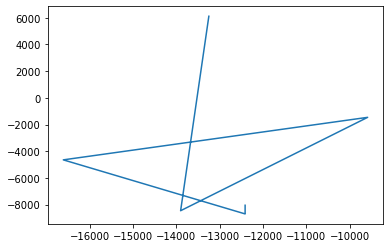

In [83]:
plt.plot(probe_data.X_stage, probe_data.Y_stage)

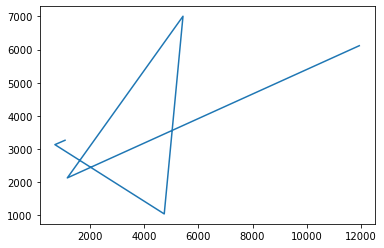

In [85]:
plt.plot(image_end_points[:,0], image_end_points[:,1])

In [198]:
image_end_points-calibrated_end_points

array([[ 106.,  134.],
       [  36., -114.],
       [  87.,  -23.],
       [-164.,  -83.],
       [-162.,  155.],
       [ -72., -108.]])

In [ ]:
#For john1 where one of the end points of one of the profiles is not well known
stage_hr_end_point = np.array([(12195, 22677)])
shear_parameter_bundle = shear_curvefit_parameter_bundle
image_hr_end_point = shear_transformer(stage_hr_end_point, shear_parameter_bundle[0], shear_parameter_bundle[1], shear_parameter_bundle[2], shear_parameter_bundle[3], shear_parameter_bundle[4], shear_parameter_bundle[5])

NameError: name 'shear_curvefit_parameter_bundle' is not defined

In [15]:
image_hr_end_point

NameError: name 'image_hr_end_point' is not defined

In [18]:
stage_profile_1 = stage_calibration_points[1]-stage_calibration_points[0]
stage_profile_2 = stage_calibration_points[3]-stage_calibration_points[2]
stage_angle = np.arccos(np.dot(stage_profile_1, stage_profile_2)/(np.linalg.norm(stage_profile_1)*np.linalg.norm(stage_profile_1)))
print(stage_angle)
image_profile_1 = image_calibration_points[1]-image_calibration_points[0]
image_profile_2 = image_calibration_points[3]-image_calibration_points[2]
image_angle = np.arccos(np.dot(image_profile_1, image_profile_2)/(np.linalg.norm(image_profile_1)*np.linalg.norm(image_profile_1)))
print(image_angle)
rote_calibrated_1 =calibrated_end_points[3]-calibrated_end_points[2]
rote_calibrated_2 = calibrated_end_points[5]-calibrated_end_points[4]
image_angle = np.arccos(np.dot(rote_calibrated_1, rote_calibrated_2)/(np.linalg.norm(rote_calibrated_1)*np.linalg.norm(rote_calibrated_2)))
print(image_angle)

1.5200036556977325
1.523597038160226
1.4388961212879854


In [19]:
#This weirdness is strange but necessary for the optimiser
stage_cal_points_for_opt = []
image_cal_points_for_opt = []

for i in range(len(stage_calibration_points)):
    stage_cal_points_for_opt.append(stage_calibration_points[i][0])
    stage_cal_points_for_opt.append(stage_calibration_points[i][1])
    image_cal_points_for_opt.append(image_calibration_points[i][0])
    image_cal_points_for_opt.append(image_calibration_points[i][1])

In [92]:
image = np.array(plt.imread('C:/users/rwfbl/Stitched_crystals/Long_wavelength_removed/John4_arith_levelled.png'))

probe_x_list = probe_data.iloc[:,9]
#print(probe_x_list[0]) #for checking that the right column was selected
probe_y_list = probe_data.iloc[:,10]
probe_points = []
for i in range(len(probe_data.iloc[:,9])):
    probe_points.append((probe_data.iloc[i,9], probe_data.iloc[i,10]))
    #print(i, probe_points[i])
probe_points = np.array(probe_points)
#probe_y_list[0]
anorthite_list = np.array((probe_data.iloc[:,4]/40.078)/((probe_data.iloc[:,4]/40.078)+(probe_data.iloc[:,1]/22.990)+(probe_data.iloc[:,6]/39.098)))
dist_list = np.array(probe_data.iloc[:,12]).astype(float)
#parameter_bundle = curvefit_parameter_bundle
#probe_points_placed = transformer(probe_points, parameter_bundle[0], parameter_bundle[1], parameter_bundle[2], parameter_bundle[3])

#shear_parameter_bundle = shear_curvefit_parameter_bundle
#probe_points_placed = shear_transformer(probe_points, shear_parameter_bundle[0], shear_parameter_bundle[1], shear_parameter_bundle[2], shear_parameter_bundle[3], shear_parameter_bundle[4], shear_parameter_bundle[5])

#probe_points_placed = rote_transformer(calibrated_end_points, do_all_profiles) 

show_points = 0
if show_points == 1:
    
    #print(probe_points_placed)
    for i in range(len(probe_points_placed)):
        draw_marker(int(probe_points_placed[i][0]), int(probe_points_placed[i][1]),4,image)
    for i in range(len(image_calibration_points)):
        draw_marker(int(image_calibration_points[i][0]), int(image_calibration_points[i][1]),4,image)
        

save = 0
if save ==1:
    
    image_boosted = image *255
    to_save = image_boosted.astype(np.uint8)
    print(np.max(to_save))
    to_save = Image.fromarray(to_save)
    to_save.save('rote_calib_200.png')

In [ ]:
#Big bad bulker



In [70]:
dist_list[0]

0.0

In [78]:
with pd.option_context("display.max_rows", 1000):
    print(anorthite_list)


[0.8609119  0.90253995 0.86813231 0.85562531 0.88095974 0.85936136
 0.90718721 0.91488782 0.88851179 0.89551474 0.90002672 0.88603628
 0.8810767  0.88413872 0.88662518 0.87654264 0.89498744 0.88338849
 0.87944869 0.87572145 0.88251223 0.88635046 0.88845913 0.88382534
 0.89080502 0.88572659 0.89188029 0.9002388  0.87936073 0.88187015
 0.87558563 0.886508   0.88652557 0.88303218 0.88600599 0.89050776
 0.88572216 0.8919505  0.88641413 0.8876488  0.88016558 0.88580693
 0.88096598 0.88352274 0.69903301 0.89103723 0.87978178 0.89009312
 0.88504079 0.89236885 0.89607503 0.89354746 0.88343035 0.88861084
 0.88532296 0.87696285 0.87986695 0.88090243 0.88954178 0.88366296
 0.87804372 0.87297456 0.88063909 0.87607569 0.88086719 0.87796389
 0.88686727 0.89420225 0.88609209 0.8782207  0.89211361 0.87993274
 0.87702356 0.88450775 0.87084278 0.87656694 0.87549071 0.88657452
 0.87685458 0.8696263  0.88792363 0.87555101 0.51137586 0.88948765
 0.8792375  0.89776626 0.8992256  0.90081985 0.91339459 0.9099

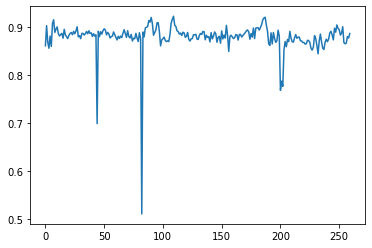

In [79]:
plt.plot(anorthite_list)

In [35]:
np.mean(image)

0.16724384

In [93]:
tile_origins[100][0]

2400

In [23]:
probe_points_placed[0, 0]

NameError: name 'probe_points_placed' is not defined

In [24]:
anorthite_list.shape

(260,)

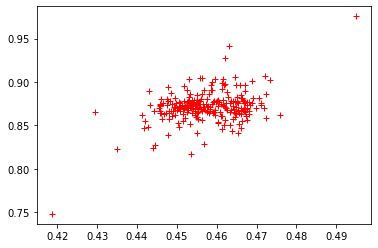

In [27]:
search_size = 3
intensity_list = []
for i in range(len(probe_points_placed)):
    #print(probe_points_placed[i][0],' ',probe_points_placed[i][1])
    intensity_list.append(get_brightness(int(probe_points_placed[i][0]),int(probe_points_placed[i][1]), search_size))
    
clean_list_entries = []
for i in range(len(probe_points_placed)):
    if intensity_list[i] >0.4 and intensity_list[i] <0.54 and anorthite_list[i]>0.6 and anorthite_list[i]<1.0:
        clean_list_entries.append(i)
    
#xlim=[0.3,0.6], ylim=[0.8,0.9]
fig, ax = plt.subplots(1,1)
intensity_array = np.array(intensity_list)
clean_intensity_array = intensity_array[clean_list_entries]
anorthite_array = np.array(anorthite_list)
clean_anorthite_array = anorthite_array[clean_list_entries]
clean_x_array = np.array(probe_points_placed)[clean_list_entries, 0]
clean_y_array = np.array(probe_points_placed)[clean_list_entries, 1]


clean_set = np.array([clean_intensity_array, clean_anorthite_array, clean_x_array, clean_y_array])
ax.plot(clean_intensity_array,clean_anorthite_array, 'r+')
#ax.set_xlim(0.48,0.55)
#ax.set_ylim(0.8,0.93)
plt.show()

In [184]:
len(probe_points_placed)

260

In [153]:
#print("X")
#for i in range(len(clean_intensity_array)):
#    print(clean_x_array[i])
#print("Y")
#for i in range(len(clean_intensity_array)):
#    print(clean_y_array[i])
#print("Intensity")
#for i in range(len(clean_intensity_array)):
#    print(clean_intensity_array[i])
#print("Real anorthite")
#for i in range(len(clean_intensity_array)):
#    print(clean_anorthite_array[i])
#print("Linear anorthite")
#for i in range(len(clean_intensity_array)):
#    print(linfit_predicted_ans[i])
#print("Squared anorthite")
#for i in range(len(clean_intensity_array)):
#    print(linfit_predicted_ans[i])
    

In [86]:
john3_tile_origins = np.array([[   55,    48],
       [   55,   749],
       [   55,  1452],
       [   55,  2155],
       [   55,  2858],
       [   55,  3560],
       [   55,  4260],
       [   55,  4961],
       [   55,  5664],
       [   55,  6366],
       [   55,  7069],
       [   55,  7771],
       [   55,  8477],
       [   55,  9180],
       [   55,  9884],
       [   55, 10586],
       [   55, 11286],
       [   55, 11987],
       [  522,    51],
       [  522,   752],
       [  522,  1455],
       [  522,  2158],
       [  522,  2861],
       [  522,  3563],
       [  522,  4263],
       [  522,  4964],
       [  522,  5667],
       [  522,  6369],
       [  522,  7072],
       [  522,  7774],
       [  522,  8480],
       [  522,  9183],
       [  522,  9887],
       [  522, 10589],
       [  522, 11289],
       [  522, 11990],
       [  993,    54],
       [  993,   755],
       [  993,  1458],
       [  993,  2161],
       [  993,  2864],
       [  993,  3566],
       [  993,  4266],
       [  993,  4967],
       [  993,  5670],
       [  993,  6372],
       [  993,  7075],
       [  993,  7777],
       [  993,  8483],
       [  993,  9186],
       [  993,  9890],
       [  993, 10592],
       [  993, 11292],
       [  993, 11993],
       [ 1461,    56],
       [ 1461,   757],
       [ 1461,  1460],
       [ 1461,  2163],
       [ 1461,  2866],
       [ 1461,  3568],
       [ 1461,  4268],
       [ 1461,  4969],
       [ 1461,  5672],
       [ 1461,  6374],
       [ 1461,  7077],
       [ 1461,  7779],
       [ 1461,  8485],
       [ 1461,  9188],
       [ 1461,  9892],
       [ 1461, 10594],
       [ 1461, 11294],
       [ 1461, 11995],
       [ 1931,    59],
       [ 1931,   760],
       [ 1931,  1463],
       [ 1931,  2166],
       [ 1931,  2869],
       [ 1931,  3571],
       [ 1931,  4271],
       [ 1931,  4972],
       [ 1931,  5675],
       [ 1931,  6377],
       [ 1931,  7080],
       [ 1931,  7782],
       [ 1931,  8488],
       [ 1931,  9191],
       [ 1931,  9895],
       [ 1931, 10597],
       [ 1931, 11297],
       [ 1931, 11998],
       [ 2400,    61],
       [ 2400,   762],
       [ 2400,  1465],
       [ 2400,  2168],
       [ 2400,  2871],
       [ 2400,  3573],
       [ 2400,  4273],
       [ 2400,  4974],
       [ 2400,  5677],
       [ 2400,  6379],
       [ 2400,  7082],
       [ 2400,  7784],
       [ 2400,  8490],
       [ 2400,  9193],
       [ 2400,  9897],
       [ 2400, 10599],
       [ 2400, 11299],
       [ 2400, 12000],
       [ 2865,    64],
       [ 2865,   765],
       [ 2865,  1468],
       [ 2865,  2171],
       [ 2865,  2874],
       [ 2865,  3576],
       [ 2865,  4276],
       [ 2865,  4977],
       [ 2865,  5680],
       [ 2865,  6382],
       [ 2865,  7085],
       [ 2865,  7787],
       [ 2865,  8493],
       [ 2865,  9196],
       [ 2865,  9900],
       [ 2865, 10602],
       [ 2865, 11302],
       [ 2865, 12003],
       [ 3335,    67],
       [ 3335,   768],
       [ 3335,  1471],
       [ 3335,  2174],
       [ 3335,  2877],
       [ 3335,  3579],
       [ 3335,  4279],
       [ 3335,  4980],
       [ 3335,  5683],
       [ 3335,  6385],
       [ 3335,  7088],
       [ 3335,  7790],
       [ 3335,  8496],
       [ 3335,  9199],
       [ 3335,  9903],
       [ 3335, 10605],
       [ 3335, 11305],
       [ 3335, 12006],
       [ 3805,    70],
       [ 3805,   771],
       [ 3805,  1474],
       [ 3805,  2177],
       [ 3805,  2880],
       [ 3805,  3582],
       [ 3805,  4282],
       [ 3805,  4983],
       [ 3805,  5686],
       [ 3805,  6388],
       [ 3805,  7091],
       [ 3805,  7793],
       [ 3805,  8499],
       [ 3805,  9202],
       [ 3805,  9906],
       [ 3805, 10608],
       [ 3805, 11308],
       [ 3805, 12009],
       [ 4272,    73],
       [ 4272,   774],
       [ 4272,  1477],
       [ 4272,  2180],
       [ 4272,  2883],
       [ 4272,  3585],
       [ 4272,  4285],
       [ 4272,  4986],
       [ 4272,  5689],
       [ 4272,  6391],
       [ 4272,  7094],
       [ 4272,  7796],
       [ 4272,  8502],
       [ 4272,  9205],
       [ 4272,  9909],
       [ 4272, 10611],
       [ 4272, 11311],
       [ 4272, 12012],
       [ 4740,    76],
       [ 4740,   777],
       [ 4740,  1480],
       [ 4740,  2183],
       [ 4740,  2886],
       [ 4740,  3588],
       [ 4740,  4288],
       [ 4740,  4989],
       [ 4740,  5692],
       [ 4740,  6394],
       [ 4740,  7097],
       [ 4740,  7799],
       [ 4740,  8505],
       [ 4740,  9208],
       [ 4740,  9912],
       [ 4740, 10614],
       [ 4740, 11314],
       [ 4740, 12015],
       [ 5204,    79],
       [ 5204,   780],
       [ 5204,  1483],
       [ 5204,  2186],
       [ 5204,  2889],
       [ 5204,  3591],
       [ 5204,  4291],
       [ 5204,  4992],
       [ 5204,  5695],
       [ 5204,  6397],
       [ 5204,  7100],
       [ 5204,  7802],
       [ 5204,  8508],
       [ 5204,  9211],
       [ 5204,  9915],
       [ 5204, 10617],
       [ 5204, 11317],
       [ 5204, 12018],
       [ 5676,    83],
       [ 5676,   784],
       [ 5676,  1487],
       [ 5676,  2190],
       [ 5676,  2893],
       [ 5676,  3595],
       [ 5676,  4295],
       [ 5676,  4996],
       [ 5676,  5699],
       [ 5676,  6401],
       [ 5676,  7104],
       [ 5676,  7806],
       [ 5676,  8512],
       [ 5676,  9215],
       [ 5676,  9919],
       [ 5676, 10621],
       [ 5676, 11321],
       [ 5676, 12022],
       [ 6142,    86],
       [ 6142,   787],
       [ 6142,  1490],
       [ 6142,  2193],
       [ 6142,  2896],
       [ 6142,  3598],
       [ 6142,  4298],
       [ 6142,  4999],
       [ 6142,  5702],
       [ 6142,  6404],
       [ 6142,  7107],
       [ 6142,  7809],
       [ 6142,  8515],
       [ 6142,  9218],
       [ 6142,  9922],
       [ 6142, 10624],
       [ 6142, 11324],
       [ 6142, 12025],
       [ 6610,    88],
       [ 6610,   789],
       [ 6610,  1492],
       [ 6610,  2195],
       [ 6610,  2898],
       [ 6610,  3600],
       [ 6610,  4300],
       [ 6610,  5001],
       [ 6610,  5704],
       [ 6610,  6406],
       [ 6610,  7109],
       [ 6610,  7811],
       [ 6610,  8517],
       [ 6610,  9220],
       [ 6610,  9924],
       [ 6610, 10626],
       [ 6610, 11326],
       [ 6610, 12027],
       [ 7080,    91],
       [ 7080,   792],
       [ 7080,  1495],
       [ 7080,  2198],
       [ 7080,  2901],
       [ 7080,  3603],
       [ 7080,  4303],
       [ 7080,  5004],
       [ 7080,  5707],
       [ 7080,  6409],
       [ 7080,  7112],
       [ 7080,  7814],
       [ 7080,  8520],
       [ 7080,  9223],
       [ 7080,  9927],
       [ 7080, 10629],
       [ 7080, 11329],
       [ 7080, 12030],
       [ 7545,    94],
       [ 7545,   795],
       [ 7545,  1498],
       [ 7545,  2201],
       [ 7545,  2904],
       [ 7545,  3606],
       [ 7545,  4306],
       [ 7545,  5007],
       [ 7545,  5710],
       [ 7545,  6412],
       [ 7545,  7115],
       [ 7545,  7817],
       [ 7545,  8523],
       [ 7545,  9226],
       [ 7545,  9930],
       [ 7545, 10632],
       [ 7545, 11332],
       [ 7545, 12033],
       [ 8017,    96],
       [ 8017,   797],
       [ 8017,  1500],
       [ 8017,  2203],
       [ 8017,  2906],
       [ 8017,  3608],
       [ 8017,  4308],
       [ 8017,  5009],
       [ 8017,  5712],
       [ 8017,  6414],
       [ 8017,  7117],
       [ 8017,  7819],
       [ 8017,  8525],
       [ 8017,  9228],
       [ 8017,  9932],
       [ 8017, 10634],
       [ 8017, 11334],
       [ 8017, 12035]])

john1_tile_origins = np.array([[ 134,   85],
       [ 134,  785],
       [ 134, 1485],
       [ 134, 2185],
       [ 134, 2885],
       [ 134, 3585],
       [ 134, 4285],
       [ 134, 4985],
       [ 134, 5685],
       [ 134, 6385],
       [ 134, 7085],
       [ 608,   73],
       [ 608,  773],
       [ 608, 1473],
       [ 608, 2173],
       [ 608, 2873],
       [ 608, 3573],
       [ 608, 4273],
       [ 608, 4973],
       [ 608, 5673],
       [ 608, 6373],
       [ 608, 7073],
       [1082,   65],
       [1082,  765],
       [1082, 1465],
       [1082, 2165],
       [1082, 2865],
       [1082, 3565],
       [1082, 4265],
       [1082, 4965],
       [1082, 5665],
       [1082, 6365],
       [1082, 7065],
       [1542,   67],
       [1542,  767],
       [1542, 1467],
       [1542, 2167],
       [1542, 2867],
       [1542, 3567],
       [1542, 4267],
       [1542, 4967],
       [1542, 5667],
       [1542, 6367],
       [1542, 7067],
       [2016,   67],
       [2016,  767],
       [2016, 1467],
       [2016, 2167],
       [2016, 2867],
       [2016, 3567],
       [2016, 4267],
       [2016, 4967],
       [2016, 5667],
       [2016, 6367],
       [2016, 7067],
       [2475,   72],
       [2475,  772],
       [2475, 1472],
       [2475, 2172],
       [2475, 2872],
       [2475, 3572],
       [2475, 4272],
       [2475, 4972],
       [2475, 5672],
       [2475, 6372],
       [2475, 7072],
       [2943,   80],
       [2943,  780],
       [2943, 1480],
       [2943, 2180],
       [2943, 2880],
       [2943, 3580],
       [2943, 4280],
       [2943, 4980],
       [2943, 5680],
       [2943, 6380],
       [2943, 7080],
       [3412,   85],
       [3412,  785],
       [3412, 1485],
       [3412, 2185],
       [3412, 2885],
       [3412, 3585],
       [3412, 4285],
       [3412, 4985],
       [3412, 5685],
       [3412, 6385],
       [3412, 7085],
       [3869,   98],
       [3869,  798],
       [3869, 1498],
       [3869, 2198],
       [3869, 2898],
       [3869, 3598],
       [3869, 4298],
       [3869, 4998],
       [3869, 5698],
       [3869, 6398],
       [3869, 7098],
       [4338,  106],
       [4338,  806],
       [4338, 1506],
       [4338, 2206],
       [4338, 2906],
       [4338, 3606],
       [4338, 4306],
       [4338, 5006],
       [4338, 5706],
       [4338, 6406],
       [4338, 7106],
       [4799,  117],
       [4799,  817],
       [4799, 1517],
       [4799, 2217],
       [4799, 2917],
       [4799, 3617],
       [4799, 4317],
       [4799, 5017],
       [4799, 5717],
       [4799, 6417],
       [4799, 7117],
       [5264,  125],
       [5264,  825],
       [5264, 1525],
       [5264, 2225],
       [5264, 2925],
       [5264, 3625],
       [5264, 4325],
       [5264, 5025],
       [5264, 5725],
       [5264, 6425],
       [5264, 7125],
       [5734,  129],
       [5734,  829],
       [5734, 1529],
       [5734, 2229],
       [5734, 2929],
       [5734, 3629],
       [5734, 4329],
       [5734, 5029],
       [5734, 5729],
       [5734, 6429],
       [5734, 7129],
       [6197,  129],
       [6197,  829],
       [6197, 1529],
       [6197, 2229],
       [6197, 2929],
       [6197, 3629],
       [6197, 4329],
       [6197, 5029],
       [6197, 5729],
       [6197, 6429],
       [6197, 7129],
       [6668,  136],
       [6668,  836],
       [6668, 1536],
       [6668, 2236],
       [6668, 2936],
       [6668, 3636],
       [6668, 4336],
       [6668, 5036],
       [6668, 5736],
       [6668, 6436],
       [6668, 7136],
       [7131,  144],
       [7131,  844],
       [7131, 1544],
       [7131, 2244],
       [7131, 2944],
       [7131, 3644],
       [7131, 4344],
       [7131, 5044],
       [7131, 5744],
       [7131, 6444],
       [7131, 7144],
       [7598,  147],
       [7598,  847],
       [7598, 1547],
       [7598, 2247],
       [7598, 2947],
       [7598, 3647],
       [7598, 4347],
       [7598, 5047],
       [7598, 5747],
       [7598, 6447],
       [7598, 7147],
       [8068,  150],
       [8068,  850],
       [8068, 1550],
       [8068, 2250],
       [8068, 2950],
       [8068, 3650],
       [8068, 4350],
       [8068, 5050],
       [8068, 5750],
       [8068, 6450],
       [8068, 7150],
       [8532,  150],
       [8532,  850],
       [8532, 1550],
       [8532, 2250],
       [8532, 2950],
       [8532, 3650],
       [8532, 4350],
       [8532, 5050],
       [8532, 5750],
       [8532, 6450],
       [8532, 7150]])

john4_tile_origins = np.array([[   17,    91],
       [   17,   785],
       [   17,  1478],
       [   17,  2172],
       [   17,  2868],
       [   17,  3564],
       [   17,  4259],
       [   17,  4954],
       [   18,  5649],
       [   18,  6343],
       [   18,  7037],
       [   18,  7731],
       [   18,  8428],
       [   18,  9124],
       [  482,    92],
       [  482,   786],
       [  482,  1479],
       [  482,  2173],
       [  482,  2869],
       [  482,  3565],
       [  482,  4260],
       [  482,  4955],
       [  483,  5650],
       [  483,  6344],
       [  483,  7038],
       [  483,  7732],
       [  483,  8429],
       [  483,  9125],
       [  947,    94],
       [  947,   788],
       [  947,  1481],
       [  947,  2175],
       [  947,  2871],
       [  947,  3567],
       [  947,  4262],
       [  947,  4957],
       [  948,  5652],
       [  948,  6346],
       [  948,  7040],
       [  948,  7734],
       [  948,  8431],
       [  948,  9127],
       [ 1412,    97],
       [ 1412,   791],
       [ 1412,  1484],
       [ 1412,  2178],
       [ 1412,  2874],
       [ 1412,  3570],
       [ 1412,  4265],
       [ 1412,  4960],
       [ 1413,  5655],
       [ 1413,  6349],
       [ 1413,  7043],
       [ 1413,  7737],
       [ 1413,  8434],
       [ 1413,  9130],
       [ 1871,    99],
       [ 1871,   793],
       [ 1871,  1486],
       [ 1871,  2180],
       [ 1871,  2876],
       [ 1871,  3572],
       [ 1871,  4267],
       [ 1871,  4962],
       [ 1872,  5657],
       [ 1872,  6351],
       [ 1872,  7045],
       [ 1872,  7739],
       [ 1872,  8436],
       [ 1872,  9132],
       [ 2338,   101],
       [ 2338,   795],
       [ 2338,  1488],
       [ 2338,  2182],
       [ 2338,  2878],
       [ 2338,  3574],
       [ 2338,  4269],
       [ 2338,  4964],
       [ 2339,  5659],
       [ 2339,  6353],
       [ 2339,  7047],
       [ 2339,  7741],
       [ 2339,  8438],
       [ 2339,  9134],
       [ 2799,   103],
       [ 2799,   797],
       [ 2799,  1490],
       [ 2799,  2184],
       [ 2799,  2880],
       [ 2799,  3576],
       [ 2799,  4271],
       [ 2799,  4966],
       [ 2800,  5661],
       [ 2800,  6355],
       [ 2800,  7049],
       [ 2800,  7743],
       [ 2800,  8440],
       [ 2800,  9136],
       [ 3264,   106],
       [ 3264,   800],
       [ 3264,  1493],
       [ 3264,  2187],
       [ 3264,  2883],
       [ 3264,  3579],
       [ 3264,  4274],
       [ 3264,  4969],
       [ 3265,  5664],
       [ 3265,  6358],
       [ 3265,  7052],
       [ 3265,  7746],
       [ 3265,  8443],
       [ 3265,  9139],
       [ 3729,   109],
       [ 3729,   803],
       [ 3729,  1496],
       [ 3729,  2190],
       [ 3729,  2886],
       [ 3729,  3582],
       [ 3729,  4277],
       [ 3729,  4972],
       [ 3730,  5667],
       [ 3730,  6361],
       [ 3730,  7055],
       [ 3730,  7749],
       [ 3730,  8446],
       [ 3730,  9142],
       [ 4189,   112],
       [ 4189,   806],
       [ 4189,  1499],
       [ 4189,  2193],
       [ 4189,  2889],
       [ 4189,  3585],
       [ 4189,  4280],
       [ 4189,  4975],
       [ 4190,  5670],
       [ 4190,  6364],
       [ 4190,  7058],
       [ 4190,  7752],
       [ 4190,  8449],
       [ 4190,  9145],
       [ 4655,   116],
       [ 4655,   810],
       [ 4655,  1503],
       [ 4655,  2197],
       [ 4655,  2893],
       [ 4655,  3589],
       [ 4655,  4284],
       [ 4655,  4979],
       [ 4656,  5674],
       [ 4656,  6368],
       [ 4656,  7062],
       [ 4656,  7756],
       [ 4656,  8453],
       [ 4656,  9149],
       [ 5116,   119],
       [ 5116,   813],
       [ 5116,  1506],
       [ 5116,  2200],
       [ 5116,  2896],
       [ 5116,  3592],
       [ 5116,  4287],
       [ 5116,  4982],
       [ 5117,  5677],
       [ 5117,  6371],
       [ 5117,  7065],
       [ 5117,  7759],
       [ 5117,  8456],
       [ 5117,  9152],
       [ 5579,   122],
       [ 5579,   816],
       [ 5579,  1509],
       [ 5579,  2203],
       [ 5579,  2899],
       [ 5579,  3595],
       [ 5579,  4290],
       [ 5579,  4985],
       [ 5580,  5680],
       [ 5580,  6374],
       [ 5580,  7068],
       [ 5580,  7762],
       [ 5580,  8459],
       [ 5580,  9155],
       [ 6044,   125],
       [ 6044,   819],
       [ 6044,  1512],
       [ 6044,  2206],
       [ 6044,  2902],
       [ 6044,  3598],
       [ 6044,  4293],
       [ 6044,  4988],
       [ 6045,  5683],
       [ 6045,  6377],
       [ 6045,  7071],
       [ 6045,  7765],
       [ 6045,  8462],
       [ 6045,  9158],
       [ 6504,   128],
       [ 6504,   822],
       [ 6504,  1515],
       [ 6504,  2209],
       [ 6504,  2905],
       [ 6504,  3601],
       [ 6504,  4296],
       [ 6504,  4991],
       [ 6505,  5686],
       [ 6505,  6380],
       [ 6505,  7074],
       [ 6505,  7768],
       [ 6505,  8465],
       [ 6505,  9161],
       [ 6971,   131],
       [ 6971,   825],
       [ 6971,  1518],
       [ 6971,  2212],
       [ 6971,  2908],
       [ 6971,  3604],
       [ 6971,  4299],
       [ 6971,  4994],
       [ 6972,  5689],
       [ 6972,  6383],
       [ 6972,  7077],
       [ 6972,  7771],
       [ 6972,  8468],
       [ 6972,  9164],
       [ 7432,   134],
       [ 7432,   828],
       [ 7432,  1521],
       [ 7432,  2215],
       [ 7432,  2911],
       [ 7432,  3607],
       [ 7432,  4302],
       [ 7432,  4997],
       [ 7433,  5692],
       [ 7433,  6386],
       [ 7433,  7080],
       [ 7433,  7774],
       [ 7433,  8471],
       [ 7433,  9167],
       [ 7897,   138],
       [ 7897,   832],
       [ 7897,  1525],
       [ 7897,  2219],
       [ 7897,  2915],
       [ 7897,  3611],
       [ 7897,  4306],
       [ 7897,  5001],
       [ 7898,  5696],
       [ 7898,  6390],
       [ 7898,  7084],
       [ 7898,  7778],
       [ 7898,  8475],
       [ 7898,  9171],
       [ 8362,   141],
       [ 8362,   835],
       [ 8362,  1528],
       [ 8362,  2222],
       [ 8362,  2918],
       [ 8362,  3614],
       [ 8362,  4309],
       [ 8362,  5004],
       [ 8363,  5699],
       [ 8363,  6393],
       [ 8363,  7087],
       [ 8363,  7781],
       [ 8363,  8478],
       [ 8363,  9174],
       [ 8822,   144],
       [ 8822,   838],
       [ 8822,  1531],
       [ 8822,  2225],
       [ 8822,  2921],
       [ 8822,  3617],
       [ 8822,  4312],
       [ 8822,  5007],
       [ 8823,  5702],
       [ 8823,  6396],
       [ 8823,  7090],
       [ 8823,  7784],
       [ 8823,  8481],
       [ 8823,  9177],
       [ 9290,   147],
       [ 9290,   841],
       [ 9290,  1534],
       [ 9290,  2228],
       [ 9290,  2924],
       [ 9290,  3620],
       [ 9290,  4315],
       [ 9290,  5010],
       [ 9291,  5705],
       [ 9291,  6399],
       [ 9291,  7093],
       [ 9291,  7787],
       [ 9291,  8484],
       [ 9291,  9180],
       [ 9753,   149],
       [ 9753,   843],
       [ 9753,  1536],
       [ 9753,  2230],
       [ 9753,  2926],
       [ 9753,  3622],
       [ 9753,  4317],
       [ 9753,  5012],
       [ 9754,  5707],
       [ 9754,  6401],
       [ 9754,  7095],
       [ 9754,  7789],
       [ 9754,  8486],
       [ 9754,  9182],
       [10215,   152],
       [10215,   846],
       [10215,  1539],
       [10215,  2233],
       [10215,  2929],
       [10215,  3625],
       [10215,  4320],
       [10215,  5015],
       [10216,  5710],
       [10216,  6404],
       [10216,  7098],
       [10216,  7792],
       [10216,  8489],
       [10216,  9185],
       [10680,   155],
       [10680,   849],
       [10680,  1542],
       [10680,  2236],
       [10680,  2932],
       [10680,  3628],
       [10680,  4323],
       [10680,  5018],
       [10681,  5713],
       [10681,  6407],
       [10681,  7101],
       [10681,  7795],
       [10681,  8492],
       [10681,  9188],
       [11139,   158],
       [11139,   852],
       [11139,  1545],
       [11139,  2239],
       [11139,  2935],
       [11139,  3631],
       [11139,  4326],
       [11139,  5021],
       [11140,  5716],
       [11140,  6410],
       [11140,  7104],
       [11140,  7798],
       [11140,  8495],
       [11140,  9191],
       [11607,   161],
       [11607,   855],
       [11607,  1548],
       [11607,  2242],
       [11607,  2938],
       [11607,  3634],
       [11607,  4329],
       [11607,  5024],
       [11608,  5719],
       [11608,  6413],
       [11608,  7107],
       [11608,  7801],
       [11608,  8498],
       [11608,  9194],
       [12070,   164],
       [12070,   858],
       [12070,  1551],
       [12070,  2245],
       [12070,  2941],
       [12070,  3637],
       [12070,  4332],
       [12070,  5027],
       [12071,  5722],
       [12071,  6416],
       [12071,  7110],
       [12071,  7804],
       [12071,  8501],
       [12071,  9197],
       [12534,   166],
       [12534,   860],
       [12534,  1553],
       [12534,  2247],
       [12534,  2943],
       [12534,  3639],
       [12534,  4334],
       [12534,  5029],
       [12535,  5724],
       [12535,  6418],
       [12535,  7112],
       [12535,  7806],
       [12535,  8503],
       [12535,  9199],
       [12998,   168],
       [12998,   862],
       [12998,  1555],
       [12998,  2249],
       [12998,  2945],
       [12998,  3641],
       [12998,  4336],
       [12998,  5031],
       [12999,  5726],
       [12999,  6420],
       [12999,  7114],
       [12999,  7808],
       [12999,  8505],
       [12999,  9201],
       [13459,   170],
       [13459,   864],
       [13459,  1557],
       [13459,  2251],
       [13459,  2947],
       [13459,  3643],
       [13459,  4338],
       [13459,  5033],
       [13460,  5728],
       [13460,  6422],
       [13460,  7116],
       [13460,  7810],
       [13460,  8507],
       [13460,  9203],
       [13926,   173],
       [13926,   867],
       [13926,  1560],
       [13926,  2254],
       [13926,  2950],
       [13926,  3646],
       [13926,  4341],
       [13926,  5036],
       [13927,  5731],
       [13927,  6425],
       [13927,  7119],
       [13927,  7813],
       [13927,  8510],
       [13927,  9206],
       [14388,   176],
       [14388,   870],
       [14388,  1563],
       [14388,  2257],
       [14388,  2953],
       [14388,  3649],
       [14388,  4344],
       [14388,  5039],
       [14389,  5734],
       [14389,  6428],
       [14389,  7122],
       [14389,  7816],
       [14389,  8513],
       [14389,  9209],
       [14853,   179],
       [14853,   873],
       [14853,  1566],
       [14853,  2260],
       [14853,  2956],
       [14853,  3652],
       [14853,  4347],
       [14853,  5042],
       [14854,  5737],
       [14854,  6431],
       [14854,  7125],
       [14854,  7819],
       [14854,  8516],
       [14854,  9212],
       [15319,   181],
       [15319,   875],
       [15319,  1568],
       [15319,  2262],
       [15319,  2958],
       [15319,  3654],
       [15319,  4349],
       [15319,  5044],
       [15320,  5739],
       [15320,  6433],
       [15320,  7127],
       [15320,  7821],
       [15320,  8518],
       [15320,  9214]])

john6_tile_origins = np.array([[   14,    32],
       [   14,   726],
       [   14,  1420],
       [   14,  2114],
       [   15,  2808],
       [   15,  3504],
       [   15,  4199],
       [   16,  4894],
       [   17,  5589],
       [   18,  6284],
       [   19,  6980],
       [   20,  7675],
       [   21,  8371],
       [   22,  9067],
       [   23,  9764],
       [   24, 10460],
       [   25, 11156],
       [   25, 11855],
       [  475,    36],
       [  475,   730],
       [  475,  1424],
       [  475,  2118],
       [  476,  2812],
       [  476,  3508],
       [  476,  4203],
       [  477,  4898],
       [  478,  5593],
       [  479,  6288],
       [  480,  6984],
       [  481,  7679],
       [  482,  8375],
       [  483,  9071],
       [  484,  9768],
       [  485, 10464],
       [  486, 11160],
       [  486, 11859],
       [  941,    39],
       [  941,   733],
       [  941,  1427],
       [  941,  2121],
       [  942,  2815],
       [  942,  3511],
       [  942,  4206],
       [  943,  4901],
       [  944,  5596],
       [  945,  6291],
       [  946,  6987],
       [  947,  7682],
       [  948,  8378],
       [  949,  9074],
       [  950,  9771],
       [  951, 10467],
       [  952, 11163],
       [  952, 11862],
       [ 1405,    42],
       [ 1405,   736],
       [ 1405,  1430],
       [ 1405,  2124],
       [ 1406,  2818],
       [ 1406,  3514],
       [ 1406,  4209],
       [ 1407,  4904],
       [ 1408,  5599],
       [ 1409,  6294],
       [ 1410,  6990],
       [ 1411,  7685],
       [ 1412,  8381],
       [ 1413,  9077],
       [ 1414,  9774],
       [ 1415, 10470],
       [ 1416, 11166],
       [ 1416, 11865],
       [ 1869,    45],
       [ 1869,   739],
       [ 1869,  1433],
       [ 1869,  2127],
       [ 1870,  2821],
       [ 1870,  3517],
       [ 1870,  4212],
       [ 1871,  4907],
       [ 1872,  5602],
       [ 1873,  6297],
       [ 1874,  6993],
       [ 1875,  7688],
       [ 1876,  8384],
       [ 1877,  9080],
       [ 1878,  9777],
       [ 1879, 10473],
       [ 1880, 11169],
       [ 1880, 11868],
       [ 2334,    48],
       [ 2334,   742],
       [ 2334,  1436],
       [ 2334,  2130],
       [ 2335,  2824],
       [ 2335,  3520],
       [ 2335,  4215],
       [ 2336,  4910],
       [ 2337,  5605],
       [ 2338,  6300],
       [ 2339,  6996],
       [ 2340,  7691],
       [ 2341,  8387],
       [ 2342,  9083],
       [ 2343,  9780],
       [ 2344, 10476],
       [ 2345, 11172],
       [ 2345, 11871],
       [ 2796,    50],
       [ 2796,   744],
       [ 2796,  1438],
       [ 2796,  2132],
       [ 2797,  2826],
       [ 2797,  3522],
       [ 2797,  4217],
       [ 2798,  4912],
       [ 2799,  5607],
       [ 2800,  6302],
       [ 2801,  6998],
       [ 2802,  7693],
       [ 2803,  8389],
       [ 2804,  9085],
       [ 2805,  9782],
       [ 2806, 10478],
       [ 2807, 11174],
       [ 2807, 11873],
       [ 3263,    53],
       [ 3263,   747],
       [ 3263,  1441],
       [ 3263,  2135],
       [ 3264,  2829],
       [ 3264,  3525],
       [ 3264,  4220],
       [ 3265,  4915],
       [ 3266,  5610],
       [ 3267,  6305],
       [ 3268,  7001],
       [ 3269,  7696],
       [ 3270,  8392],
       [ 3271,  9088],
       [ 3272,  9785],
       [ 3273, 10481],
       [ 3274, 11177],
       [ 3274, 11876],
       [ 3726,    56],
       [ 3726,   750],
       [ 3726,  1444],
       [ 3726,  2138],
       [ 3727,  2832],
       [ 3727,  3528],
       [ 3727,  4223],
       [ 3728,  4918],
       [ 3729,  5613],
       [ 3730,  6308],
       [ 3731,  7004],
       [ 3732,  7699],
       [ 3733,  8395],
       [ 3734,  9091],
       [ 3735,  9788],
       [ 3736, 10484],
       [ 3737, 11180],
       [ 3737, 11879],
       [ 4190,    59],
       [ 4190,   753],
       [ 4190,  1447],
       [ 4190,  2141],
       [ 4191,  2835],
       [ 4191,  3531],
       [ 4191,  4226],
       [ 4192,  4921],
       [ 4193,  5616],
       [ 4194,  6311],
       [ 4195,  7007],
       [ 4196,  7702],
       [ 4197,  8398],
       [ 4198,  9094],
       [ 4199,  9791],
       [ 4200, 10487],
       [ 4201, 11183],
       [ 4201, 11882],
       [ 4657,    61],
       [ 4657,   755],
       [ 4657,  1449],
       [ 4657,  2143],
       [ 4658,  2837],
       [ 4658,  3533],
       [ 4658,  4228],
       [ 4659,  4923],
       [ 4660,  5618],
       [ 4661,  6313],
       [ 4662,  7009],
       [ 4663,  7704],
       [ 4664,  8400],
       [ 4665,  9096],
       [ 4666,  9793],
       [ 4667, 10489],
       [ 4668, 11185],
       [ 4668, 11884],
       [ 5118,    64],
       [ 5118,   758],
       [ 5118,  1452],
       [ 5118,  2146],
       [ 5119,  2840],
       [ 5119,  3536],
       [ 5119,  4231],
       [ 5120,  4926],
       [ 5121,  5621],
       [ 5122,  6316],
       [ 5123,  7012],
       [ 5124,  7707],
       [ 5125,  8403],
       [ 5126,  9099],
       [ 5127,  9796],
       [ 5128, 10492],
       [ 5129, 11188],
       [ 5129, 11887]])

john8_tile_origins = np.array([[   24,    79],
       [   25,   774],
       [   26,  1466],
       [   27,  2159],
       [   28,  2854],
       [   29,  3547],
       [   30,  4241],
       [   31,  4939],
       [   32,  5635],
       [   33,  6332],
       [   34,  7029],
       [   35,  7725],
       [   36,  8422],
       [   37,  9118],
       [   38,  9813],
       [   39, 10510],
       [   40, 11206],
       [  489,    82],
       [  490,   777],
       [  491,  1469],
       [  492,  2162],
       [  493,  2857],
       [  494,  3550],
       [  495,  4244],
       [  496,  4942],
       [  497,  5638],
       [  498,  6335],
       [  499,  7032],
       [  500,  7728],
       [  501,  8425],
       [  502,  9121],
       [  503,  9816],
       [  504, 10513],
       [  505, 11209],
       [  951,    85],
       [  952,   780],
       [  953,  1472],
       [  954,  2165],
       [  955,  2860],
       [  956,  3553],
       [  957,  4247],
       [  958,  4945],
       [  959,  5641],
       [  960,  6338],
       [  961,  7035],
       [  962,  7731],
       [  963,  8428],
       [  964,  9124],
       [  965,  9819],
       [  966, 10516],
       [  967, 11212],
       [ 1415,    87],
       [ 1416,   782],
       [ 1417,  1474],
       [ 1418,  2167],
       [ 1419,  2862],
       [ 1420,  3555],
       [ 1421,  4249],
       [ 1422,  4947],
       [ 1423,  5643],
       [ 1424,  6340],
       [ 1425,  7037],
       [ 1426,  7733],
       [ 1427,  8430],
       [ 1428,  9126],
       [ 1429,  9821],
       [ 1430, 10518],
       [ 1431, 11214],
       [ 1875,    90],
       [ 1876,   785],
       [ 1877,  1477],
       [ 1878,  2170],
       [ 1879,  2865],
       [ 1880,  3558],
       [ 1881,  4252],
       [ 1882,  4950],
       [ 1883,  5646],
       [ 1884,  6343],
       [ 1885,  7040],
       [ 1886,  7736],
       [ 1887,  8433],
       [ 1888,  9129],
       [ 1889,  9824],
       [ 1890, 10521],
       [ 1891, 11217],
       [ 2341,    90],
       [ 2342,   785],
       [ 2343,  1477],
       [ 2344,  2170],
       [ 2345,  2865],
       [ 2346,  3558],
       [ 2347,  4252],
       [ 2348,  4950],
       [ 2349,  5646],
       [ 2350,  6343],
       [ 2351,  7040],
       [ 2352,  7736],
       [ 2353,  8433],
       [ 2354,  9129],
       [ 2355,  9824],
       [ 2356, 10521],
       [ 2357, 11217],
       [ 2804,    88],
       [ 2805,   783],
       [ 2806,  1475],
       [ 2807,  2168],
       [ 2808,  2863],
       [ 2809,  3556],
       [ 2810,  4250],
       [ 2811,  4948],
       [ 2812,  5644],
       [ 2813,  6341],
       [ 2814,  7038],
       [ 2815,  7734],
       [ 2816,  8431],
       [ 2817,  9127],
       [ 2818,  9822],
       [ 2819, 10519],
       [ 2820, 11215],
       [ 3266,    92],
       [ 3267,   787],
       [ 3268,  1479],
       [ 3269,  2172],
       [ 3270,  2867],
       [ 3271,  3560],
       [ 3272,  4254],
       [ 3273,  4952],
       [ 3274,  5648],
       [ 3275,  6345],
       [ 3276,  7042],
       [ 3277,  7738],
       [ 3278,  8435],
       [ 3279,  9131],
       [ 3280,  9826],
       [ 3281, 10523],
       [ 3282, 11219],
       [ 3733,    96],
       [ 3734,   791],
       [ 3735,  1483],
       [ 3736,  2176],
       [ 3737,  2871],
       [ 3738,  3564],
       [ 3739,  4258],
       [ 3740,  4956],
       [ 3741,  5652],
       [ 3742,  6349],
       [ 3743,  7046],
       [ 3744,  7742],
       [ 3745,  8439],
       [ 3746,  9135],
       [ 3747,  9830],
       [ 3748, 10527],
       [ 3749, 11223],
       [ 4193,    99],
       [ 4194,   794],
       [ 4195,  1486],
       [ 4196,  2179],
       [ 4197,  2874],
       [ 4198,  3567],
       [ 4199,  4261],
       [ 4200,  4959],
       [ 4201,  5655],
       [ 4202,  6352],
       [ 4203,  7049],
       [ 4204,  7745],
       [ 4205,  8442],
       [ 4206,  9138],
       [ 4207,  9833],
       [ 4208, 10530],
       [ 4209, 11226],
       [ 4659,   102],
       [ 4660,   797],
       [ 4661,  1489],
       [ 4662,  2182],
       [ 4663,  2877],
       [ 4664,  3570],
       [ 4665,  4264],
       [ 4666,  4962],
       [ 4667,  5658],
       [ 4668,  6355],
       [ 4669,  7052],
       [ 4670,  7748],
       [ 4671,  8445],
       [ 4672,  9141],
       [ 4673,  9836],
       [ 4674, 10533],
       [ 4675, 11229],
       [ 5123,   105],
       [ 5124,   800],
       [ 5125,  1492],
       [ 5126,  2185],
       [ 5127,  2880],
       [ 5128,  3573],
       [ 5129,  4267],
       [ 5130,  4965],
       [ 5131,  5661],
       [ 5132,  6358],
       [ 5133,  7055],
       [ 5134,  7751],
       [ 5135,  8448],
       [ 5136,  9144],
       [ 5137,  9839],
       [ 5138, 10536],
       [ 5139, 11232],
       [ 5586,   108],
       [ 5587,   803],
       [ 5588,  1495],
       [ 5589,  2188],
       [ 5590,  2883],
       [ 5591,  3576],
       [ 5592,  4270],
       [ 5593,  4968],
       [ 5594,  5664],
       [ 5595,  6361],
       [ 5596,  7058],
       [ 5597,  7754],
       [ 5598,  8451],
       [ 5599,  9147],
       [ 5600,  9842],
       [ 5601, 10539],
       [ 5602, 11235],
       [ 6051,   111],
       [ 6052,   806],
       [ 6053,  1498],
       [ 6054,  2191],
       [ 6055,  2886],
       [ 6056,  3579],
       [ 6057,  4273],
       [ 6058,  4971],
       [ 6059,  5667],
       [ 6060,  6364],
       [ 6061,  7061],
       [ 6062,  7757],
       [ 6063,  8454],
       [ 6064,  9150],
       [ 6065,  9845],
       [ 6066, 10542],
       [ 6067, 11238],
       [ 6512,   114],
       [ 6513,   809],
       [ 6514,  1501],
       [ 6515,  2194],
       [ 6516,  2889],
       [ 6517,  3582],
       [ 6518,  4276],
       [ 6519,  4974],
       [ 6520,  5670],
       [ 6521,  6367],
       [ 6522,  7064],
       [ 6523,  7760],
       [ 6524,  8457],
       [ 6525,  9153],
       [ 6526,  9848],
       [ 6527, 10545],
       [ 6528, 11241],
       [ 6978,   117],
       [ 6979,   812],
       [ 6980,  1504],
       [ 6981,  2197],
       [ 6982,  2892],
       [ 6983,  3585],
       [ 6984,  4279],
       [ 6985,  4977],
       [ 6986,  5673],
       [ 6987,  6370],
       [ 6988,  7067],
       [ 6989,  7763],
       [ 6990,  8460],
       [ 6991,  9156],
       [ 6992,  9851],
       [ 6993, 10548],
       [ 6994, 11244],
       [ 7442,   121],
       [ 7443,   816],
       [ 7444,  1508],
       [ 7445,  2201],
       [ 7446,  2896],
       [ 7447,  3589],
       [ 7448,  4283],
       [ 7449,  4981],
       [ 7450,  5677],
       [ 7451,  6374],
       [ 7452,  7071],
       [ 7453,  7767],
       [ 7454,  8464],
       [ 7455,  9160],
       [ 7456,  9855],
       [ 7457, 10552],
       [ 7458, 11248],
       [ 7905,   125],
       [ 7906,   820],
       [ 7907,  1512],
       [ 7908,  2205],
       [ 7909,  2900],
       [ 7910,  3593],
       [ 7911,  4287],
       [ 7912,  4985],
       [ 7913,  5681],
       [ 7914,  6378],
       [ 7915,  7075],
       [ 7916,  7771],
       [ 7917,  8468],
       [ 7918,  9164],
       [ 7919,  9859],
       [ 7920, 10556],
       [ 7921, 11252],
       [ 8374,   129],
       [ 8375,   824],
       [ 8376,  1516],
       [ 8377,  2209],
       [ 8378,  2904],
       [ 8379,  3597],
       [ 8380,  4291],
       [ 8381,  4989],
       [ 8382,  5685],
       [ 8383,  6382],
       [ 8384,  7079],
       [ 8385,  7775],
       [ 8386,  8472],
       [ 8387,  9168],
       [ 8388,  9863],
       [ 8389, 10560],
       [ 8390, 11256],
       [ 8834,   132],
       [ 8835,   827],
       [ 8836,  1519],
       [ 8837,  2212],
       [ 8838,  2907],
       [ 8839,  3600],
       [ 8840,  4294],
       [ 8841,  4992],
       [ 8842,  5688],
       [ 8843,  6385],
       [ 8844,  7082],
       [ 8845,  7778],
       [ 8846,  8475],
       [ 8847,  9171],
       [ 8848,  9866],
       [ 8849, 10563],
       [ 8850, 11259],
       [ 9301,   135],
       [ 9302,   830],
       [ 9303,  1522],
       [ 9304,  2215],
       [ 9305,  2910],
       [ 9306,  3603],
       [ 9307,  4297],
       [ 9308,  4995],
       [ 9309,  5691],
       [ 9310,  6388],
       [ 9311,  7085],
       [ 9312,  7781],
       [ 9313,  8478],
       [ 9314,  9174],
       [ 9315,  9869],
       [ 9316, 10566],
       [ 9317, 11262],
       [ 9766,   139],
       [ 9767,   834],
       [ 9768,  1526],
       [ 9769,  2219],
       [ 9770,  2914],
       [ 9771,  3607],
       [ 9772,  4301],
       [ 9773,  4999],
       [ 9774,  5695],
       [ 9775,  6392],
       [ 9776,  7089],
       [ 9777,  7785],
       [ 9778,  8482],
       [ 9779,  9178],
       [ 9780,  9873],
       [ 9781, 10570],
       [ 9782, 11266],
       [10229,   142],
       [10230,   837],
       [10231,  1529],
       [10232,  2222],
       [10233,  2917],
       [10234,  3610],
       [10235,  4304],
       [10236,  5002],
       [10237,  5698],
       [10238,  6395],
       [10239,  7092],
       [10240,  7788],
       [10241,  8485],
       [10242,  9181],
       [10243,  9876],
       [10244, 10573],
       [10245, 11269],
       [10696,   145],
       [10697,   840],
       [10698,  1532],
       [10699,  2225],
       [10700,  2920],
       [10701,  3613],
       [10702,  4307],
       [10703,  5005],
       [10704,  5701],
       [10705,  6398],
       [10706,  7095],
       [10707,  7791],
       [10708,  8488],
       [10709,  9184],
       [10710,  9879],
       [10711, 10576],
       [10712, 11272],
       [11158,   147],
       [11159,   842],
       [11160,  1534],
       [11161,  2227],
       [11162,  2922],
       [11163,  3615],
       [11164,  4309],
       [11165,  5007],
       [11166,  5703],
       [11167,  6400],
       [11168,  7097],
       [11169,  7793],
       [11170,  8490],
       [11171,  9186],
       [11172,  9881],
       [11173, 10578],
       [11174, 11274],
       [11624,   149],
       [11625,   844],
       [11626,  1536],
       [11627,  2229],
       [11628,  2924],
       [11629,  3617],
       [11630,  4311],
       [11631,  5009],
       [11632,  5705],
       [11633,  6402],
       [11634,  7099],
       [11635,  7795],
       [11636,  8492],
       [11637,  9188],
       [11638,  9883],
       [11639, 10580],
       [11640, 11276],
       [12088,   152],
       [12089,   847],
       [12090,  1539],
       [12091,  2232],
       [12092,  2927],
       [12093,  3620],
       [12094,  4314],
       [12095,  5012],
       [12096,  5708],
       [12097,  6405],
       [12098,  7102],
       [12099,  7798],
       [12100,  8495],
       [12101,  9191],
       [12102,  9886],
       [12103, 10583],
       [12104, 11279],
       [12550,   156],
       [12551,   851],
       [12552,  1543],
       [12553,  2236],
       [12554,  2931],
       [12555,  3624],
       [12556,  4318],
       [12557,  5016],
       [12558,  5712],
       [12559,  6409],
       [12560,  7106],
       [12561,  7802],
       [12562,  8499],
       [12563,  9195],
       [12564,  9890],
       [12565, 10587],
       [12566, 11283]])

In [69]:
tile_origins = john3_tile_origins
clean_set_by_tile = []
for i in range(len(tile_origins)):
    clean_set_in_tile = []
    for j in range(len(clean_set[0])):
        if clean_set[3,j]>tile_origins[i][0] and clean_set[3,j]<tile_origins[i][0]+512 and clean_set[2,j]>tile_origins[i][1] and clean_set[2, j]<tile_origins[i][1]+768:
            clean_set_in_tile.append(clean_set[:,j])
          
    clean_set_in_tile = np.array(clean_set_in_tile)
    clean_set_by_tile.append(clean_set_in_tile)

In [70]:
clean_set_by_tile = np.array(clean_set_by_tile, dtype=object)

In [249]:
#clean_set_populated_tiles

In [250]:
#clean_set_populated_tiles[7]

In [71]:
clean_set_populated_tiles = []
for i in range(len(clean_set_by_tile)):
    if len(clean_set_by_tile[i])>6:
        clean_set_populated_tiles.append(clean_set_by_tile[i])
        #print(i)
    

In [130]:
tile_origins[78]

array([1931, 4271])

In [131]:
tile_origins[79]

array([1931, 4972])

In [72]:
for i in range(len(clean_set_populated_tiles)):
    
    print(np.corrcoef(clean_set_populated_tiles[i][:,0], clean_set_populated_tiles[i][:,1])[0,1])

0.07295878257339239
0.6399996034690988
0.7315263025351962
0.5769744962400105
0.8824379740063827
0.7591643758368285
0.8474488237034052
0.5191193149816117
0.49661257574321693
0.28825270576768985
0.5443159611826963
0.23075981168325235
0.41757078873059217
0.4825809784087945
0.9719557387325914
0.295082099689122
0.7899420871280284
0.8586890050048401
0.03910340013547083
0.6737973616810096
0.5436086854925612


In [73]:
tilewise_anint_params = []
tilewise_predicted_ans = []
for i in range(len(clean_set_populated_tiles)):
    tile_model = LinearRegression()
    #tile_independents = np.transpose(np.array([clean_set_populated_tiles[i][:,2], clean_set_populated_tiles[i][:,3], clean_set_populated_tiles[i][:,0]]))
    tile_independents = np.array(clean_set_populated_tiles[i][:,0]).reshape(-1, 1)
    tile_dependents = clean_set_populated_tiles[i][:,1]
    tile_model.fit(tile_independents, tile_dependents)
    predictions = tile_model.predict(tile_independents)
    tilewise_predicted_ans.append(np.array(predictions))
    tilewise_anint_params.append(np.append(tile_model.coef_,tile_model.intercept_))

In [74]:
tilewise_anint_params

[array([0.34619421, 0.70688982]),
 array([0.93560226, 0.44440208]),
 array([ 2.70647566, -0.35217609]),
 array([0.65075513, 0.56243467]),
 array([ 3.15320223, -0.57593779]),
 array([ 3.92565791, -0.9094558 ]),
 array([ 2.52640449, -0.30997477]),
 array([1.17772945, 0.33397795]),
 array([ 2.37986869, -0.20807444]),
 array([0.40100686, 0.69125531]),
 array([1.52849478, 0.18426382]),
 array([0.32661415, 0.72631291]),
 array([0.40814104, 0.6873471 ]),
 array([1.35253859, 0.24962341]),
 array([ 2.37602388, -0.20471368]),
 array([1.57547907, 0.15687979]),
 array([0.62395266, 0.59007771]),
 array([1.80921568, 0.0659357 ]),
 array([0.09021848, 0.85590611]),
 array([ 2.25360613, -0.15193066]),
 array([ 2.72077385, -0.37004317])]

In [61]:
tile_to_see = 12
print(clean_set_populated_tiles[tile_to_see])
print("Anorthites")
for i in range(len(clean_set_populated_tiles[tile_to_see][:,0])):
    print(clean_set_populated_tiles[tile_to_see][i,1])
print("Intensities")
for i in range(len(clean_set_populated_tiles[tile_to_see][:,0])):
    print(clean_set_populated_tiles[tile_to_see][i,0])
print("x")
for i in range(len(clean_set_populated_tiles[tile_to_see][:,0])):
    print(clean_set_populated_tiles[tile_to_see][i,2])
print("y")
for i in range(len(clean_set_populated_tiles[tile_to_see][:,0])):
    print(clean_set_populated_tiles[tile_to_see][i,3])

IndexError: list index out of range

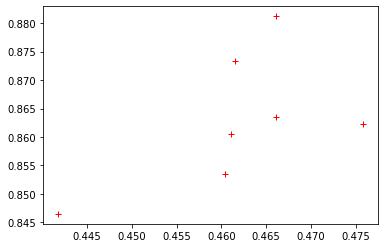

In [37]:
#x = np.linspace(0.5, 0.53, 20)
tile_to_see = 3
plt.plot(clean_set_populated_tiles[tile_to_see][:,0], clean_set_populated_tiles[tile_to_see][:,1], 'r+')

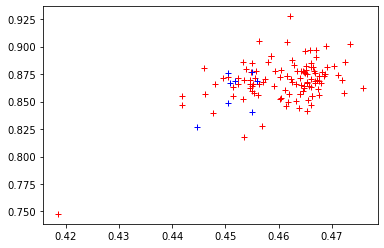

In [67]:
fig, ax = plt.subplots()
tile_to_see = np.array([0,1,2,3,4,5,6,7])
tile_to_consider = np.array([20])
#tile_to_consider = np.array([6])
for i in tile_to_see:
    ax.plot(clean_set_populated_tiles[i][:,0], clean_set_populated_tiles[i][:,1], 'r+')
for i in tile_to_consider:
    ax.plot(clean_set_populated_tiles[i][:,0], clean_set_populated_tiles[i][:,1], 'b+')
#ax.plot(x, (x*tilewise_anint_params[7][0]+tilewise_anint_params[7][1]))
plt.show()
#John4 7 is high res

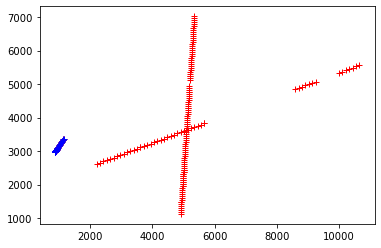

In [278]:
fig, ax = plt.subplots()
for i in tile_to_see:
    ax.plot(clean_set_populated_tiles[i][:,2], clean_set_populated_tiles[i][:,3], 'r+')
for i in tile_to_consider:
    ax.plot(clean_set_populated_tiles[i][:,2], clean_set_populated_tiles[i][:,3], 'b+')
plt.show()

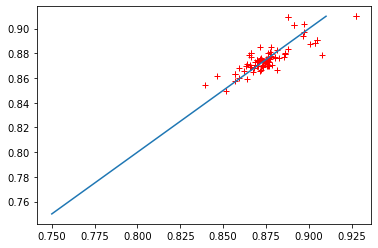

In [156]:
fig, ax = plt.subplots()
tile_to_see = np.array([0,1,2,3,4,5,6,7,8,9,10])
for i in tile_to_see:
    ax.plot(clean_set_populated_tiles[i][:,1], tilewise_predicted_ans[i], 'r+')
ax.plot(x,x)
plt.show()

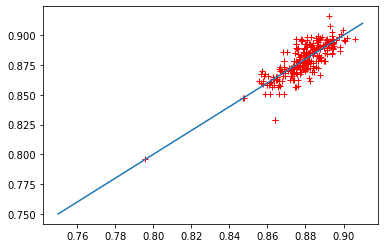

In [107]:
fig, ax = plt.subplots()
tile_to_see = np.array([0,1,2,3,4,5,6,7,8,9,11, 12, 13, 14, 15])
for i in tile_to_see:
    ax.plot(tilewise_predicted_ans[i], clean_set_populated_tiles[i][:,1] , 'r+')
ax.plot(x,x)
plt.show()

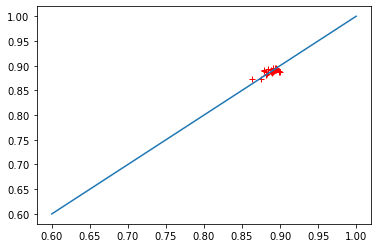

In [100]:
tile_to_see = 4
plt.plot(clean_set_populated_tiles[tile_to_see][:,1], tilewise_predicted_ans[tile_to_see], 'r+')
plt.plot(x, x)
#plt.plot(clean_set_populated_tiles[tile_to_see][:,1], clean_set_populated_tiles[tile_to_see][:,1], 'b+')

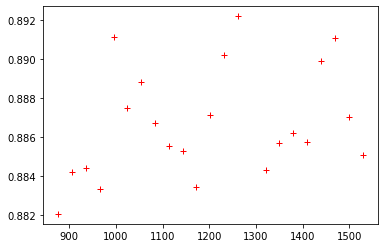

In [83]:
tile_to_see = 5
plt.plot(clean_set_populated_tiles[tile_to_see][:,2], tilewise_predicted_ans[tile_to_see], 'r+')

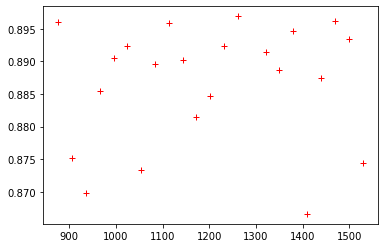

In [84]:
#tile_to_see = 3
plt.plot(clean_set_populated_tiles[tile_to_see][:,2],clean_set_populated_tiles[tile_to_see][:,1], 'r+')

array([0.88176192, 0.87300062, 0.88654137, 0.87731377, 0.88263348,
       0.86327857, 0.86903411])

In [202]:
#clean_set[1, :]

In [201]:
#for i in range(clean_set.shape[1]):
#    print(clean_set[0,i], clean_set[1,i])

In [17]:
#dist_list

In [91]:
def rote_transformer(image_end_points, profiles_to_transform):
    
    #Transforms the points by taking the calibration points as rote truth
    
    probe_points_placed = []
    for i in range(len(profiles_to_transform)):
        j = int(profiles_to_transform[i])
        if j == len(profile_start_numbers)-1:
            points_in_profile = probe_points[profile_start_numbers[j]:len(probe_points)]
            dist_in_profile = dist_list[profile_start_numbers[j]:len(probe_points)]
        else:
            points_in_profile = probe_points[profile_start_numbers[j]:profile_start_numbers[j+1]]
            dist_in_profile = dist_list[profile_start_numbers[j]:profile_start_numbers[j+1]]
        
        profile_start = image_end_points[2*i]
        profile_end =  image_end_points[(2*i)+1]
        profile_vector = profile_end-profile_start
        relative_dist = dist_in_profile/np.max(dist_in_profile)
        #print(profile_vector)
        #print(profile_start)
        #print(profile_end)
        #print(points_in_profile)
        #print(relative_dist)
        for k in range(len(relative_dist)):
            probe_points_placed.append(np.round((profile_start + (relative_dist[k]*profile_vector))))
    return np.array(probe_points_placed)

In [40]:
rote_placed = rote_transformer(probe_points, image_end_points, [0,1,2]) 

In [199]:
#image

In [273]:
i = 0
print(len(probe_points[profile_start_numbers[i]:profile_start_numbers[i+1]]))
i = 1
print(len(probe_points[profile_start_numbers[i]:profile_start_numbers[i+1]]))

IndexError: index 3 is out of bounds for axis 0 with size 3

In [275]:
i = 2
print(len(probe_points[profile_start_numbers[i]:len(profile_start_numbers)]))

0


In [90]:
def rote_evaluator(rote_parameter_bundle):
    
    #This function exists for the genetic optimiser, it needs to be a function which takes a parameter bundle (for the rote transformer the parameters are only the profile concerned's number and image coordinates of its end points)
    #and returns a number which is smaller for better results
    rote_parameter_bundle = np.round(rote_parameter_bundle)
    if isinstance(rote_parameter_bundle[0], np.float64):
        profiles_in_question = [rote_parameter_bundle[0]]
    else:
        profiles_in_question = rote_parameter_bundle[0]
    points_from_params = []
    for i in range(int(((len(rote_parameter_bundle)-1))/2)):
        point_from_params = (rote_parameter_bundle[(2*i)+1], rote_parameter_bundle[(2*i)+2]) #convert 1d params list into set of tuples representing end points
        points_from_params.append(point_from_params)
    points_from_params = np.array(points_from_params)
    
    #data_point_numbers = [profile_start_numbers[profile_in_question], profile_start_numbers[profile_in_question+1]]
    #relevant_probe_points = probe_points[data_point_numbers[0]:data_point_numbers[1]]
    placed_points = rote_transformer(points_from_params, profiles_in_question)
    correl_score = correlation_scorer(placed_points, profiles_in_question)
    
    return 100*(1-correl_score)
    

In [47]:
thing = [1]

1

In [28]:
probe_points[0:10]

array([[11507. , 22382. ],
       [11511.6, 22384. ],
       [11516.2, 22385.9],
       [11520.8, 22387.9],
       [11525.4, 22389.9],
       [11530. , 22391.9],
       [11534.6, 22393.8],
       [11539.2, 22395.8],
       [11543.8, 22397.8],
       [11548.4, 22399.7]])

In [89]:
def rote_calibrator(end_points, play):
    
    #Function which looks at different combinations of end points near where they are expected to be
    end_values = end_points.flatten()
    calibrated_end_points = []
    
    for i in range(int(len(end_points)/2)):
        parameter_bounds = []
        parameter_bounds.append([i-0.1,i+0.1])
        for j in range(4):
            parameter_bounds.append([end_values[(4*i)+j]-play,end_values[(4*i)+j]+play])

        genetic_parameters = differential_evolution(rote_evaluator, parameter_bounds, seed = 7, maxiter=500, popsize=50).x #The seed is for the random number generator, setting it leads to stable results
        genetic_parameters = np.round(genetic_parameters)
        calibrated_end_points.append([genetic_parameters[1], genetic_parameters[2]])
        calibrated_end_points.append([genetic_parameters[3], genetic_parameters[4]])
        print("Just finished profile ", i, "so far: ", calibrated_end_points)
        print("This profile got this score: ", rote_evaluator(genetic_parameters))
    
    return calibrated_end_points, rote_evaluator(genetic_parameters)

In [158]:
correlation_scorer(probe_points_placed, do_all_profiles)

In [154]:
correlation_scorer(probe_points_placed, do_all_profiles)

0.395773850357447

In [ ]:
rote_calibrator(image_end_points, 200)

In [12]:
def analytic_calibrator(stage_point_1, stage_point_2, image_point_1, image_point_2):

    #Transforms the stage coordinates to image coordinates based on exactly two points
    
    #Set these values

    #for John1
    stage_start = np.array(stage_point_1) #These can be any two points for which the stage coordinates are known
    stage_end = np.array(stage_point_2) #In the form (x,y) which is probably technically suboptimal but is definitely easier to read
    image_start = np.array(image_point_1) #These must be the same two points on the image
    image_end = np.array(image_point_2)
    
    #Do not touch
    
    #Transformation we want is distinctly stage coordinates -> image coordinates
    
    #We do this in three steps, taking advantage of the knowledge that both coordinate systems are square grids
    
    stage_calibration_vector = stage_end - stage_start #Our goal is to transform this stage vector into the image vector while preserving the square-gridness
    image_calibration_vector = image_end - image_start #This tranformation should then be able to be applied to other points 
    
    stage_cal_length = np.sqrt(stage_calibration_vector[0]**2 + stage_calibration_vector[1]**2)
    image_cal_length = np.sqrt(image_calibration_vector[0]**2 + image_calibration_vector[1]**2)
    stage_cal_normalised = np.array([(stage_calibration_vector[0]/stage_cal_length),(stage_calibration_vector[1]/stage_cal_length)])
    image_cal_normalised = np.array([(image_calibration_vector[0]/image_cal_length),(image_calibration_vector[1]/image_cal_length)])
    stage_to_image_scale = image_cal_length/stage_cal_length
    #print(stage_to_image_scale)
    #print(stage_calibration_vector)
    #print(image_calibration_vector)
    
    theta_from_cos = np.arccos((stage_cal_normalised[0]*image_cal_normalised[0]) + (stage_cal_normalised[1]*image_cal_normalised[1]))
    #print(stage_cal_normalised)
    #print(image_cal_normalised)
    #print(theta_from_cos)
    theta = np.pi + np.arcsin((image_cal_normalised[1]-stage_cal_normalised[1]*np.cos(theta_from_cos))/stage_cal_normalised[0]) #There definitely exists a better way to do this but it works
    
    return stage_to_image_scale, theta, image_start[0], image_start[1]
    
    
def transformer(probe_points, stage_to_image_scale, theta, x_offset, y_offset):
    
    #probe_x_list = []
    #probe_y_list = []
    #for i in range(len(probe_points)):
        #probe_x_list.append(probe_points[i][0])
        #probe_y_list.append(probe_points[i][1])
        
    #Now onto the actual transformation
    probe_x_centred = probe_points[:,0] - stage_calibration_points[0][0]
    probe_y_centred = probe_points[:,1] - stage_calibration_points[0][1]
    #print(probe_x_centred)
    #plt.plot(probe_x_centred, probe_y_centred, 'r+')   
    
    probe_x_scaled = probe_x_centred * stage_to_image_scale
    probe_y_scaled = probe_y_centred * stage_to_image_scale
    
    #plt.plot(probe_x_scaled, probe_y_scaled, 'r+')
    
    probe_x_rotated = probe_x_scaled*np.cos(theta) + probe_y_scaled*np.sin(theta)
    probe_y_rotated = probe_x_scaled*np.sin(theta) - probe_y_scaled*np.cos(theta)
    
    #plt.plot(probe_x_rotated, probe_y_rotated, 'r+')
    
    probe_x_placed = np.round(probe_x_rotated) + np.round(x_offset)
    probe_y_placed = np.round(probe_y_rotated) + np.round(y_offset)
    
    #plt.plot(probe_x_placed, probe_y_placed, 'r+')
    
    probe_points_placed = []
    for i in range(len(probe_points)):
        #probe_points_placed.append((probe_x_placed[i], probe_y_placed[i],probe_x_placed[i], probe_y_placed[i],probe_y_placed[i]))
        probe_points_placed.append((probe_x_placed[i], probe_y_placed[i]))
    probe_points_placed = np.array(probe_points_placed)    
    
    #plt.plot(probe_points_placed[:,0],probe_points_placed[:,1], 'r+')
    
    return probe_points_placed

def shear_transformer(probe_points, stage_to_image_scale, theta, x_offset, y_offset, x_shear, y_shear):
    
    #probe_x_list = []
    #probe_y_list = []
    #for i in range(len(probe_points)):
        #probe_x_list.append(probe_points[i][0])
        #probe_y_list.append(probe_points[i][1])
        
    #Now onto the actual transformation
    probe_x_centred = probe_points[:,0] - stage_calibration_points[0][0]
    probe_y_centred = probe_points[:,1] - stage_calibration_points[0][1]
    #print(probe_x_centred)
    #plt.plot(probe_x_centred, probe_y_centred, 'r+')   
    
#    probe_x_sheared = probe_x_centred + shear*probe_y_centred
#    probe_y_sheared = probe_y_centred + shear*probe_x_centred
#    
#    probe_x_scaled = probe_x_sheared * stage_to_image_scale
#    probe_y_scaled = probe_y_sheared * stage_to_image_scale

    probe_x_scaled = probe_x_centred * stage_to_image_scale
    probe_y_scaled = probe_y_centred * stage_to_image_scale
    
    #plt.plot(probe_x_scaled, probe_y_scaled, 'r+')
    
    probe_x_rotated = probe_x_scaled*np.cos(theta) + probe_y_scaled*np.sin(theta)
    probe_y_rotated = probe_x_scaled*np.sin(theta) - probe_y_scaled*np.cos(theta)
    
    probe_x_sheared = probe_x_rotated + x_shear*probe_y_rotated
    probe_y_sheared = probe_y_rotated + y_shear*probe_x_rotated
    
    #plt.plot(probe_x_rotated, probe_y_rotated, 'r+')
    
#    probe_x_placed = np.round(probe_x_rotated) + np.round(x_offset)
#    probe_y_placed = np.round(probe_y_rotated) + np.round(y_offset)

    probe_x_placed = np.round(probe_x_sheared) + np.round(x_offset)
    probe_y_placed = np.round(probe_y_sheared) + np.round(y_offset)

    
    #plt.plot(probe_x_placed, probe_y_placed, 'r+')
    
    probe_points_placed = []
    for i in range(len(probe_points)):
        #probe_points_placed.append((probe_x_placed[i], probe_y_placed[i],probe_x_placed[i], probe_y_placed[i],probe_y_placed[i]))
        probe_points_placed.append((probe_x_placed[i], probe_y_placed[i]))
    probe_points_placed = np.array(probe_points_placed)    
    
    #plt.plot(probe_points_placed[:,0],probe_points_placed[:,1], 'r+')
    
    return probe_points_placed


In [13]:
def transformer_for_opt(optimiser_points, stage_to_image_scale, theta, x_offset, y_offset):
    
    probe_x_list = []
    probe_y_list = []
    for i in range(int(len(optimiser_points)/2)):
        probe_x_list.append(optimiser_points[2*i])
        probe_y_list.append(optimiser_points[(2*i)+1])
        
    #Now onto the actual transformation
    probe_x_centred = probe_x_list - stage_calibration_points[0][0]
    probe_y_centred = probe_y_list - stage_calibration_points[0][1]
    #print(probe_x_centred)
    #plt.plot(probe_x_centred, probe_y_centred, 'r+')   
    
    probe_x_scaled = probe_x_centred * stage_to_image_scale
    probe_y_scaled = probe_y_centred * stage_to_image_scale
    
    #plt.plot(probe_x_scaled, probe_y_scaled, 'r+')
    
    probe_x_rotated = probe_x_scaled*np.cos(theta) + probe_y_scaled*np.sin(theta)
    probe_y_rotated = probe_x_scaled*np.sin(theta) - probe_y_scaled*np.cos(theta)
    
    #plt.plot(probe_x_rotated, probe_y_rotated, 'r+')
    
    probe_x_placed = np.round(probe_x_rotated) + x_offset
    probe_y_placed = np.round(probe_y_rotated) + y_offset
    
    #plt.plot(probe_x_placed, probe_y_placed, 'r+')
    
    probe_points_placed = []
    for i in range(int(len(optimiser_points)/2)):
        #probe_points_placed.append((probe_x_placed[i], probe_y_placed[i],probe_x_placed[i], probe_y_placed[i],probe_y_placed[i]))
        probe_points_placed.append(probe_x_placed[i])
        probe_points_placed.append(probe_y_placed[i])
    probe_points_placed = np.array(probe_points_placed)    
    
    #plt.plot(probe_points_placed[:,0],probe_points_placed[:,1], 'r+')
    
    return probe_points_placed

def shear_transformer_for_opt(optimiser_points, stage_to_image_scale, theta, x_offset, y_offset, x_shear, y_shear):
    
    probe_x_list = []
    probe_y_list = []
    for i in range(int(len(optimiser_points)/2)):
        probe_x_list.append(optimiser_points[2*i])
        probe_y_list.append(optimiser_points[(2*i)+1])
        
    #Now onto the actual transformation
    probe_x_centred = probe_x_list - stage_calibration_points[0][0]
    probe_y_centred = probe_y_list - stage_calibration_points[0][1]
    #print(probe_x_centred)
    #plt.plot(probe_x_centred, probe_y_centred, 'r+')   
    
#    probe_x_sheared = probe_x_centred + shear*probe_y_centred
#    probe_y_sheared = probe_y_centred + shear*probe_x_centred
#    
#    probe_x_scaled = probe_x_sheared * stage_to_image_scale
#    probe_y_scaled = probe_y_sheared * stage_to_image_scale

    probe_x_scaled = probe_x_centred * stage_to_image_scale
    probe_y_scaled = probe_y_centred * stage_to_image_scale
    
    #plt.plot(probe_x_scaled, probe_y_scaled, 'r+')
    
    probe_x_rotated = probe_x_scaled*np.cos(theta) + probe_y_scaled*np.sin(theta)
    probe_y_rotated = probe_x_scaled*np.sin(theta) - probe_y_scaled*np.cos(theta)
    
    probe_x_sheared = probe_x_rotated + x_shear*probe_y_rotated
    probe_y_sheared = probe_y_rotated + y_shear*probe_x_rotated
    
    #plt.plot(probe_x_rotated, probe_y_rotated, 'r+')
    
#    probe_x_placed = np.round(probe_x_rotated) + np.round(x_offset)
#    probe_y_placed = np.round(probe_y_rotated) + np.round(y_offset)

    probe_x_placed = np.round(probe_x_sheared) + np.round(x_offset)
    probe_y_placed = np.round(probe_y_sheared) + np.round(y_offset)
    
    #plt.plot(probe_x_placed, probe_y_placed, 'r+')
    
    probe_points_placed = []
    for i in range(int(len(optimiser_points)/2)):
        #probe_points_placed.append((probe_x_placed[i], probe_y_placed[i],probe_x_placed[i], probe_y_placed[i],probe_y_placed[i]))
        probe_points_placed.append(probe_x_placed[i])
        probe_points_placed.append(probe_y_placed[i])
    probe_points_placed = np.array(probe_points_placed)    
    
    #plt.plot(probe_points_placed[:,0],probe_points_placed[:,1], 'r+')
    
    return probe_points_placed

In [14]:
#probe_points[:,0]
#transformer(probe_points, analytic_parameter_bundle[0], analytic_parameter_bundle[1], analytic_parameter_bundle[2], analytic_parameter_bundle[3])

In [15]:
def statistical_calibrator():
    
    #Transforms the stage coordinates to image coordinates with the same methodology as above
    #but finds the parameters for the transformation statistically using as many points as have been supplied
    

    
    
    #Find starting parameters, since I already have an approximate method for doing this, I may as well start the search off in very nearly the "right place" and search a relatively narrow range
    
    analytic_parameter_bundle = analytic_calibrator(stage_calibration_points[0], stage_calibration_points[1], image_calibration_points[0], image_calibration_points[1])
    max_stage_to_image_scale = analytic_parameter_bundle[0]*2 #This should be easily large enough in each direction and scales
    min_stage_to_image_scale = analytic_parameter_bundle[0]*-2 #in case in future this is used in a context with a very different scale factor
    max_theta = analytic_parameter_bundle[1] + (np.pi/6) #Sixty degrees of play ought to be enough
    min_theta = analytic_parameter_bundle[1] - (np.pi/6)
    #max_x_centring = (analytic_parameter_bundle[2]*1.1) + 100*np.sign(analytic_parameter_bundle[2]) #This is less obvious
    #min_x_centring = (analytic_parameter_bundle[2]*0.9) - 100*np.sign(analytic_parameter_bundle[2]) #but should work for most cases
    #max_y_centring = (analytic_parameter_bundle[3]*1.1) + 100*np.sign(analytic_parameter_bundle[3])
    #min_y_centring = (analytic_parameter_bundle[3]*0.9) - 100*np.sign(analytic_parameter_bundle[3])
    max_x_offset = (analytic_parameter_bundle[2]*1.1) + 100*np.sign(analytic_parameter_bundle[2]) #These ranges are quite large
    min_x_offset = (analytic_parameter_bundle[2]*0.9) - 100*np.sign(analytic_parameter_bundle[2]) #ultimately larger is better
    max_y_offset = (analytic_parameter_bundle[3]*1.1) + 100*np.sign(analytic_parameter_bundle[3]) #so long as it still runs in a 
    min_y_offset = (analytic_parameter_bundle[3]*0.9) - 100*np.sign(analytic_parameter_bundle[3]) #reasonable time
    
    parameter_bounds = []
    parameter_bounds.append([min_stage_to_image_scale,max_stage_to_image_scale])
    parameter_bounds.append([min_theta,max_theta])
    #parameter_bounds.append([min_x_centring,max_x_centring])
    #parameter_bounds.append([min_y_centring,max_y_centring])
    parameter_bounds.append([min_x_offset,max_x_offset])
    parameter_bounds.append([min_y_offset,max_y_offset])
    
    genetic_parameters = differential_evolution(mean_of_squared_error, parameter_bounds, seed = 7, maxiter=1000, popsize=100).x #The seed is for the random number generator, setting it leads to stable results
    
    fitted_parameters, pcov = curve_fit(transformer_for_opt, stage_cal_points_for_opt, image_cal_points_for_opt, genetic_parameters)
    return genetic_parameters, fitted_parameters

In [16]:
def shear_statistical_calibrator():
    
    #Transforms the stage coordinates to image coordinates with the same methodology as above
    #but finds the parameters for the transformation statistically using as many points as have been supplied
    

    
    
    #Find starting parameters, since I already have an approximate method for doing this, I may as well start the search off in very nearly the "right place" and search a relatively narrow range
    
    analytic_parameter_bundle = analytic_calibrator(stage_calibration_points[0], stage_calibration_points[1], image_calibration_points[0], image_calibration_points[1])
    max_stage_to_image_scale = analytic_parameter_bundle[0]*2 #This should be easily large enough in each direction and scales
    min_stage_to_image_scale = analytic_parameter_bundle[0]*-2 #in case in future this is used in a context with a very different scale factor
    max_theta = analytic_parameter_bundle[1] + (np.pi/6) #Sixty degrees of play ought to be enough
    min_theta = analytic_parameter_bundle[1] - (np.pi/6)
    #max_x_centring = (analytic_parameter_bundle[2]*1.1) + 100*np.sign(analytic_parameter_bundle[2]) #This is less obvious
    #min_x_centring = (analytic_parameter_bundle[2]*0.9) - 100*np.sign(analytic_parameter_bundle[2]) #but should work for most cases
    #max_y_centring = (analytic_parameter_bundle[3]*1.1) + 100*np.sign(analytic_parameter_bundle[3])
    #min_y_centring = (analytic_parameter_bundle[3]*0.9) - 100*np.sign(analytic_parameter_bundle[3])
    max_x_offset = (analytic_parameter_bundle[2]*1.1) + 100*np.sign(analytic_parameter_bundle[2]) #These ranges are quite large
    min_x_offset = (analytic_parameter_bundle[2]*0.9) - 100*np.sign(analytic_parameter_bundle[2]) #ultimately larger is better
    max_y_offset = (analytic_parameter_bundle[3]*1.1) + 100*np.sign(analytic_parameter_bundle[3]) #so long as it still runs in a 
    min_y_offset = (analytic_parameter_bundle[3]*0.9) - 100*np.sign(analytic_parameter_bundle[3]) #reasonable time
    max_x_shear = 0.5 #This should be plenty enough even for particularly egregious miss-positionings
    min_x_shear = -0.5 
    max_y_shear = 0.5 #This should be plenty enough even for particularly egregious miss-positionings
    min_y_shear = -0.5 
    
    parameter_bounds = []
    parameter_bounds.append([min_stage_to_image_scale,max_stage_to_image_scale])
    parameter_bounds.append([min_theta,max_theta])
    #parameter_bounds.append([min_x_centring,max_x_centring])
    #parameter_bounds.append([min_y_centring,max_y_centring])
    parameter_bounds.append([min_x_offset,max_x_offset])
    parameter_bounds.append([min_y_offset,max_y_offset])
    parameter_bounds.append([min_x_shear,max_x_shear])
    parameter_bounds.append([min_y_shear,max_y_shear])
    
    shear_genetic_parameters = differential_evolution(mean_of_squared_error, parameter_bounds, seed = 7, maxiter=1000, popsize=100).x #The seed is for the random number generator, setting it leads to stable results
    
    shear_fitted_parameters, pcov = curve_fit(shear_transformer_for_opt, stage_cal_points_for_opt, image_cal_points_for_opt, shear_genetic_parameters)
    return shear_genetic_parameters, shear_fitted_parameters

In [17]:
#for i in range(len(probe_points_placed[:,0])):
#    print(probe_points_placed[i,1])

In [18]:
def mean_of_squared_error(parameter_bundle):
    
    #Computes the mean squared error of position of the calibration points for a given transformer parameter bundle
    
    #print(parameter_bundle)
    if len(parameter_bundle) == 4:
        image_points = transformer(stage_calibration_points, parameter_bundle[0], parameter_bundle[1], parameter_bundle[2], parameter_bundle[3])
    elif len(parameter_bundle) == 6:
        image_points = shear_transformer(stage_calibration_points, parameter_bundle[0], parameter_bundle[1], parameter_bundle[2], parameter_bundle[3],parameter_bundle[4], parameter_bundle[5])
    total = 0
    #print(image_points)
    for i in range(len(image_points)):
        total = total + ((image_points[i][0]-image_calibration_points[i][0])**2) + ((image_points[i][1]-image_calibration_points[i][1])**2)
        #print(((image_points[i][0]-image_calibration_points[i][0])**2) + ((image_points[i][1]-image_calibration_points[i][1])**2))
    return (total/len(image_points))

In [88]:
def correlation_scorer(probe_points_placed, profiles_in_question):
    search_size = 3
    relevant_intensities = []
    for i in range(len(probe_points_placed)):
        #print(probe_points_placed[i][0],' ',probe_points_placed[i][1])
        relevant_intensities.append(get_brightness(int(probe_points_placed[i][0]),int(probe_points_placed[i][1]), search_size))
    relevant_intensities = np.array(relevant_intensities)
    relevant_intensities = relevant_intensities.flatten()
    relevant_anorthites = []
    for i in range(len(profiles_in_question)):
        j = int(profiles_in_question[i])
        if j == len(profile_start_numbers)-1:
            relevant_anorthites.extend(np.array(anorthite_list[profile_start_numbers[j]:len(probe_points)]))
        else:
            relevant_anorthites.extend(np.array(anorthite_list[profile_start_numbers[j]:profile_start_numbers[j+1]]))
    
    relevant_anorthites = np.array(relevant_anorthites)
    relevant_anorthites =  relevant_anorthites.flatten()
    #print(relevant_anorthites.shape)
    #print(relevant_intensities.shape)
    #print(relevant_anorthites)
    #print(relevant_intensities)
    correlation_thing = np.transpose(np.column_stack((relevant_intensities, relevant_anorthites)))
    #print(correlation_thing.shape)
    cross_correlation = np.corrcoef(correlation_thing)[0,1]
    #print(cross_correlation)
    return cross_correlation

In [20]:
def full_fit_scorer(probe_points_placed, profiles_in_question):
    search_size = 2
    relevant_intensities = []
    for i in range(len(probe_points_placed)):
        #print(probe_points_placed[i][0],' ',probe_points_placed[i][1])
        relevant_intensities.append(get_brightness(int(probe_points_placed[i][0]),int(probe_points_placed[i][1]), search_size))
    relevant_intensities = np.array(relevant_intensities)
    relevant_intensities = relevant_intensities.flatten()
    relevant_anorthites = []
    relevant_x = []
    relevant_y = []
    for i in range(len(profiles_in_question)):
        j = int(profiles_in_question[i])
        if j == len(profile_start_numbers)-1:
            relevant_anorthites.extend(np.array(anorthite_list[profile_start_numbers[j]:len(probe_points)]))
            relevant_x.extend(np.array(probe_points_placed[0, profile_start_numbers[j]:len(probe_points)]))
            relevant_y.extend(np.array(probe_points_placed[1, profile_start_numbers[j]:len(probe_points)]))
        else:
            relevant_anorthites.extend(np.array(anorthite_list[profile_start_numbers[j]:profile_start_numbers[j+1]]))
            relevant_x.extend(np.array(probe_points_placed[0, profile_start_numbers[j]:profile_start_numbers[j+1]]))
            relevant_y.extend(np.array(probe_points_placed[1, profile_start_numbers[j]:profile_start_numbers[j+1]]))
    relevant_anorthites = np.array(relevant_anorthites)
    relevant_anorthites =  relevant_anorthites.flatten()
    relevant_x = np.array(relevant_x)
    relevant_x =  relevant_x.flatten()
    relevant_y = np.array(relevant_y)
    relevant_y =  relevant_y.flatten()
    

In [ ]:
parameter_bundle = curvefit_parameter_bundle
probe_points_placed = transformer(probe_points, parameter_bundle[0], parameter_bundle[1], parameter_bundle[2], parameter_bundle[3])
correlation_scorer(probe_points_placed)
shear_parameter_bundle = shear_curvefit_parameter_bundle
probe_points_placed = shear_transformer(probe_points, shear_parameter_bundle[0], shear_parameter_bundle[1], shear_parameter_bundle[2], shear_parameter_bundle[3], shear_parameter_bundle[4], shear_parameter_bundle[5])
correlation_scorer(probe_points_placed)
probe_points_placed = rote_transformer(probe_points, image_end_points, profile_start_numbers) 
correlation_scorer(probe_points_placed)


In [311]:
correlation_thing = np.transpose(np.column_stack((intensity_array, intensity_array)))
np.corrcoef(correlation_thing)

array([[1., 1.],
       [1., 1.]])

In [12]:
for i in range(len(stage_calibration_points)):
    for j in range(len(stage_calibration_points)):
        if i != j:
            analytic_parameter_bundle = analytic_calibrator(stage_calibration_points[i], stage_calibration_points[j], image_calibration_points[i], image_calibration_points[j])
            print(analytic_parameter_bundle)
            print(sum_of_squared_error(analytic_parameter_bundle))

NameError: name 'analytic_calibrator' is not defined

In [18]:
hand_parameters = np.array((0.77, 2.5, 7000, 8300))
sum_of_squared_error(hand_parameters)

13751.25

In [42]:
analytic_parameter_bundle = analytic_calibrator(stage_calibration_points[0], stage_calibration_points[1], image_calibration_points[0], image_calibration_points[1])
genetic_parameter_bundle = statistical_calibrator()[0]
curvefit_parameter_bundle = statistical_calibrator()[1]
print(analytic_parameter_bundle)
print(mean_of_squared_error(analytic_parameter_bundle))
print(genetic_parameter_bundle)
print(mean_of_squared_error(genetic_parameter_bundle))
print(curvefit_parameter_bundle)
print(mean_of_squared_error(curvefit_parameter_bundle))

C:\Users\rwfbl\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(0.7842000987543746, 2.4854150249494142, 7105, 8468)
29874.6
[7.80749866e-01 2.50513644e+00 7.11354869e+03 8.46305544e+03]
962.8
[7.80749866e-01 2.50513644e+00 7.11380000e+03 8.46200000e+03]
961.8


In [43]:
shear_genetic_parameter_bundle, shear_curvefit_parameter_bundle = shear_statistical_calibrator()

In [44]:
print(shear_genetic_parameter_bundle)
print(mean_of_squared_error(shear_genetic_parameter_bundle))
print(shear_curvefit_parameter_bundle)
print(mean_of_squared_error(shear_curvefit_parameter_bundle))

[ 7.68878838e-01  2.34457257e+00  7.11633433e+03  8.47068554e+03
 -1.59415255e-01  1.66634650e-01]
918.2
[ 7.68878838e-01  2.34457257e+00  7.11633433e+03  8.47068554e+03
 -1.59415255e-01  1.66634650e-01]
918.2


In [45]:
shear_placed = shear_transformer(probe_points, shear_genetic_parameter_bundle[0], shear_genetic_parameter_bundle[1], shear_genetic_parameter_bundle[2], shear_genetic_parameter_bundle[3], shear_genetic_parameter_bundle[4])
stage_profile_1 = stage_calibration_points[1]-stage_calibration_points[0]
stage_profile_2 = stage_calibration_points[3]-stage_calibration_points[2]
stage_angle = np.arccos(np.dot(stage_profile_1, stage_profile_2)/(np.linalg.norm(stage_profile_1)*np.linalg.norm(stage_profile_1)))
print(stage_angle)
image_profile_1 = image_calibration_points[1]-image_calibration_points[0]
image_profile_2 = image_calibration_points[3]-image_calibration_points[2]
image_angle = np.arccos(np.dot(image_profile_1, image_profile_2)/(np.linalg.norm(image_profile_1)*np.linalg.norm(image_profile_1)))
print(image_angle)
sheared_profile_1 =shear_placed[65]-shear_placed[155]
sheared_profile_2 = shear_placed[165]-shear_placed[255]
sheared_angle = np.arccos(np.dot(sheared_profile_1, sheared_profile_2)/(np.linalg.norm(sheared_profile_1)*np.linalg.norm(sheared_profile_1)))
print(sheared_angle)


TypeError: shear_transformer() missing 1 required positional argument: 'y_shear'

In [23]:
genetic_parameter_bundle = statistical_calibrator()
print(sum_of_squared_error(genetic_parameter_bundle))

print(sum_of_squared_error(fitted_parameters))
print(fitted_parameters)

NameError: name 'genetic_parameter_bundle' is not defined

In [226]:
stage_calibration_points[:][0]

array([13310, 33553])

In [468]:
sum_of_squared_error(genetic_parameter_bundle)

[[6580.4973133  7389.73205911]
 [1668.4973133  1010.73205911]
 [1309.4973133  2962.73205911]
 [3251.4973133   951.73205911]]
1148054.4409651242
303629.35699871695
9975130.431996152
8483949.521356385


19910763.751316376

In [87]:
def get_brightness(x,y,size): #Gets the mean brightness of a square extending size units out in each direction 
    #brightness_array = []
    #for i in range((2*size)+1):
    #    for j in range((2*size)+1):
    #        brightness_array.append(image[y-size+i][x-size+j])
    
    brightness_array = image[y-size:y+size+1, x-size:x+size+1]
    brightness_array = brightness_array.flatten()
    return np.mean(brightness_array)
    #return np.median(brightness_array)

In [22]:
#def mapping_func(anint_parameter_bundle):
#    x = np.array(clean_set[2,:])
#    y = np.array(clean_set[3,:])
#    intensity = np.array(clean_set[0,:])
#    x_offset, x_coeff, y_offset, y_coeff, intensity_offset, intensity_coeff, offset = anint_parameter_bundle
#    anorthite_predicted = (x-x_offset)*x_coeff + (y-y_offset)*y_coeff + intensity_coeff*(intensity-intensity_offset)+offset 
#    return np.array(anorthite_predicted)

In [315]:
def mapping_func(anint_parameter_bundle):
    x = np.array(clean_set[2,:])
    y = np.array(clean_set[3,:])
    intensity = np.array(clean_set[0,:])
    if len(anint_parameter_bundle) == 4:
        anint_parameter_bundle = np.insert(anint_parameter_bundle, 1, 0)
        anint_parameter_bundle = np.insert(anint_parameter_bundle, 3, 0)
        anint_parameter_bundle = np.insert(anint_parameter_bundle, 5, 0)
    if len(anint_parameter_bundle) == 5:
        anint_parameter_bundle = np.insert(anint_parameter_bundle, 1, 0)
        anint_parameter_bundle = np.insert(anint_parameter_bundle, 3, 0)
            
    #x_coeff, y_coeff, intensity_coeff, offset = anint_parameter_bundle
    x_coeff, x2_coeff, y_coeff, y2_coeff, intensity_coeff, intensity_squared_coeff, offset = anint_parameter_bundle
    #anorthite_predicted = (x)*x_coeff + (y)*y_coeff + intensity_coeff*(intensity)+offset 
    #anorthite_predicted = x*x_coeff+y*y_coeff+intensity_coeff*intensity+intensity_squared_coeff*(intensity**2)+offset
    anorthite_predicted = x*x_coeff+ (x**2)*x2_coeff+y*y_coeff+(y**2)*y2_coeff+intensity_coeff*intensity+intensity_squared_coeff*(intensity**2)+offset
    return np.array(anorthite_predicted)

In [161]:
def draw_marker(x,y,size, image): #Draws a marker on the image so you can check if you have selected the correct start and end points
    for i in range((2*size)+1):
        image[y-size+i][x] = 1
    for j in range((2*size)+1):
        image[y][x-size+j] = 1
    return image

In [318]:
def get_anint_params(clean_set):
    #anint parameter bundle  = x_coefficient, y_coefficient, intensity_coefficient, offset
#    parameter_bounds = []
#    parameter_bounds.append([-5000,5000])
#    parameter_bounds.append([-1/1000,1/1000])
#    parameter_bounds.append([-5000,5000])
#    parameter_bounds.append([-1/1000,1/1000])
#    parameter_bounds.append([-1,1])
#    parameter_bounds.append([-10,10])
#    parameter_bounds.append([-10,10])
    
    parameter_bounds = []

#    parameter_bounds.append([-1/10000,1/10000])
#    parameter_bounds.append([-1/10000,1/10000])
#    parameter_bounds.append([-20,20])
#    parameter_bounds.append([-20,20])
#    parameter_bounds.append([-10000,10000])

#    parameter_bounds.append([-1/1000,1/1000])
#    parameter_bounds.append([-1/1000,1/1000])
#    parameter_bounds.append([tilewise_anint_params[7][0]*0.9,tilewise_anint_params[7][0]*1.1])
#    parameter_bounds.append([-10000,10000])

    parameter_bounds.append([-1/1000,1/1000])
    parameter_bounds.append([-1/1000,1/1000])
    parameter_bounds.append([-1/1000,1/1000])
    parameter_bounds.append([-1/1000,1/1000])
    parameter_bounds.append([tilewise_anint_params[7][0]*0.9,tilewise_anint_params[7][0]*1.1])
    parameter_bounds.append([-0.000001, 0.0000001])
    parameter_bounds.append([-100000,100000])

    
    genetic_anint_parameters = differential_evolution(anint_mean_squared_error, parameter_bounds, seed = 7, maxiter=1000, popsize=100).x
    return genetic_anint_parameters

In [163]:
def anint_mean_squared_error(anint_parameter_bundle):
    probe_ans = clean_set[1,:]
    predicted_ans = mapping_func(anint_parameter_bundle)
    point_errors = []
    for i in range(len(probe_ans)):
        point_errors.append((probe_ans[i]-predicted_ans[i])**2)
    total_error = np.sum(point_errors)
    return total_error/len(point_errors)

In [164]:
def get_expected_intensities(anint_parameter_bundle):
    
    x = np.array(clean_set[2,:])
    y = np.array(clean_set[3,:])
    anorthite = np.array(clean_set[1,:])
    x_coeff, y_coeff, intensity_coeff, offset = anint_parameter_bundle
    intensities = (anorthite - ((x)*x_coeff + (y)*y_coeff + offset))/intensity_coeff
    
    return intensities

In [165]:
def draw_intensity_squares(intensities, size):
    for i in range(len(intensities)):
        x = int(clean_set[2,i])
        y = int(clean_set[3,i])
        image[y-size-1:y+size+2,x-size-1:x+size+2] = 1
        image[y-size:y+size+1,x-size:x+size+1] = intensities[i]
        

In [166]:
def draw_intensity_comparison(intensities, size, column_spacing, filename):
    height = int(np.ceil((np.sqrt(len(intensities))/10)))*10
    width = int(np.ceil(len(intensities)/height))
    units = 2*(size+1)
    baseline = np.zeros((height*units, width*(3*units+column_spacing)))
    for i in range(len(intensities)):
        y_placement = units*np.mod(i, height) +size
        x_placement = (3*units+column_spacing)*np.floor_divide(i, height) +size
        baseline[y_placement-size:y_placement+size+1, x_placement-size: x_placement+size+1] = image[int(clean_set[3,i]-size):int(clean_set[3,i]+size+1),int(clean_set[2,i]-size):int(clean_set[2,i]+size+1)]
        x_placement = x_placement + units
        baseline[y_placement-size:y_placement+size+1, x_placement-size: x_placement+size+1] = clean_set[0,i]
        x_placement = x_placement + units
        baseline[y_placement-size:y_placement+size+1, x_placement-size: x_placement+size+1] = intensities[i]
    name = filename+".tif"
    baseline = baseline *((256*256)-1)
    to_save = baseline.astype(np.uint16)
    to_save = Image.fromarray(to_save)
    to_save.save(name)
    return baseline

In [22]:
size = 4
for i in range(len(clean_set[3])):
    print(i)
    print(image[int(clean_set[3,i]-size):int(clean_set[3,i]+size+1),int(clean_set[2,i]-size):int(clean_set[2,i]+size+1)])


NameError: name 'clean_set' is not defined

In [156]:
draw_intensity_comparison(get_expected_intensities(multi_lin_reg_parameter_bundle), 4, 9, "intensity_comparison_wide")

array([[27709.99904752, 27915.9998104 , 28117.00064957, ...,
            0.        ,     0.        ,     0.        ],
       [28029.00003925, 28190.99952042, 28304.99973401, ...,
            0.        ,     0.        ,     0.        ],
       [28298.99982557, 28338.99921522, 28415.99999338, ...,
            0.        ,     0.        ,     0.        ],
       ...,
       [33052.99954981, 32744.00035858, 33360.99875629, ...,
            0.        ,     0.        ,     0.        ],
       [32467.00067908, 33044.99967188, 32675.99944308, ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ]])

In [79]:
draw_intensity_squares(get_expected_intensities(multi_lin_reg_parameter_bundle), 4)


In [90]:
len(image[0, 5-4:5+4+1])

9

In [80]:
to_save = Image.fromarray(image)
to_save.save('expected_intensities.tif')

In [319]:
anint_parameter_bundle = get_anint_params(clean_set)

In [320]:
print(anint_parameter_bundle)

[ 3.44745260e-05 -2.56029712e-09 -6.41854616e-06  7.93946469e-10
  3.73640548e+00 -4.97898095e-07 -1.11172795e+00]


In [321]:
squaredfit_predicted_ans = mapping_func(anint_parameter_bundle)

In [322]:
anint_mean_squared_error(anint_parameter_bundle)

0.00020921650447521033

In [324]:
model = LinearRegression()
independents = np.transpose(np.array([clean_set[2], clean_set[2]**2, clean_set[3],  clean_set[3]**2, clean_set[0],clean_set[0]**2]))
dependents = clean_set[1]
#ind_train, ind_test, dep_train, dep_test = train_test_split( 
#    independents, dependents, test_size=0.3, random_state=7) 
model.fit(independents, dependents)

LinearRegression()

In [325]:
multi_lin_predict = model.predict(independents)
#genetic_predict = mapping_func(anint_parameter_bundle)

print('mean_squared_error for multi lin: ', mean_squared_error(clean_set[1], multi_lin_predict)) 
#print('mean_squared_error for genetic: ', mean_squared_error(clean_set[1], genetic_predict)) 




mean_squared_error for multi lin:  0.00018839370314469985


In [285]:
multi_lin_reg_parameter_bundle = np.append(model.coef_,model.intercept_)

In [249]:
print(multi_lin_reg_parameter_bundle)
linfit_predicted_ans = mapping_func(multi_lin_reg_parameter_bundle)

[ 4.12226048e-06 -3.14992794e-06  2.66029140e+01 -2.62760649e+01
 -5.83468035e+00]


In [192]:
#linfit_predicted_ans

In [193]:
#model.predict(independents)

In [158]:
len(linfit_predicted_ans)

258

In [159]:
len(squaredfit_predicted_ans)

258

In [194]:
anint_mean_squared_error(multi_lin_reg_parameter_bundle)

0.00011605042750845133

In [168]:
anint_mean_squared_error(anint_parameter_bundle)

0.00016202288712032262

In [156]:
model.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': False,
 'positive': False}

In [341]:
print(np.max(multi_lin_predict), np.min(multi_lin_predict))
print(np.max(squaredfit_predicted_ans), np.min(squaredfit_predicted_ans))
print(np.max(clean_set[1]), np.min(clean_set[1]))


0.9615001661810787 0.7957191992473733
0.9799745895703929 0.7693001523308667
0.9758325162195595 0.7477947412694583


In [251]:
model.score(independents, dependents)

0.26866163891197936

In [191]:
print(anint_sum_of_squared_error(anint_parameter_bundle))

NameError: name 'anint_sum_of_squared_error' is not defined

In [192]:
print(anint_parameter_bundle)

NameError: name 'anint_parameter_bundle' is not defined

In [ ]:
#old anint params
#[-2.28197631e+03 -2.18965047e-07  4.56878803e+02 -2.12759749e-06
#  5.30254008e-01  1.11776470e+00  9.52672984e-01]

In [170]:
#for i in range(len(clean_set[1,:])):
#    print(clean_set[0,i])

In [171]:
#predicted_ans = mapping_func(anint_parameter_bundle)
#for i in range(len(clean_set[1,:])):
#    print(predicted_ans[i])

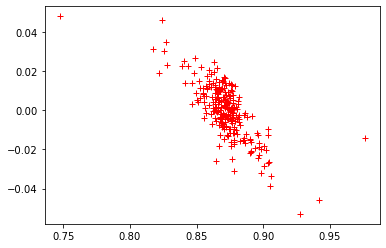

In [339]:
plt.plot(clean_set[1,:], (multi_lin_predict-clean_set[1,:]), 'r+')   

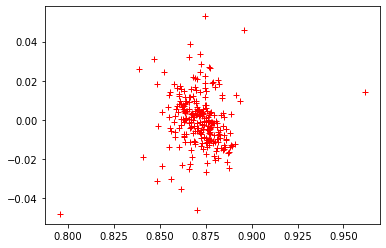

In [338]:
plt.plot(multi_lin_predict, (clean_set[1,:]-multi_lin_predict), 'r+')   

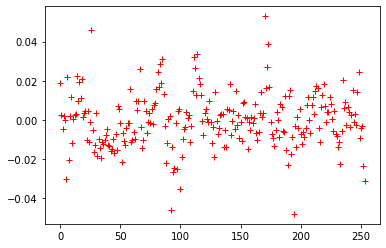

In [337]:
plt.plot((clean_set[1,:]-multi_lin_predict), 'r+')   

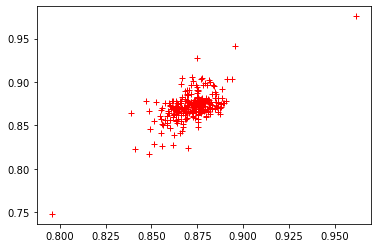

In [336]:
plt.plot(multi_lin_predict, clean_set[1,:], 'r+')  

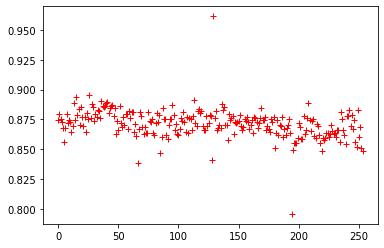

In [327]:
plt.plot(multi_lin_predict, 'r+')

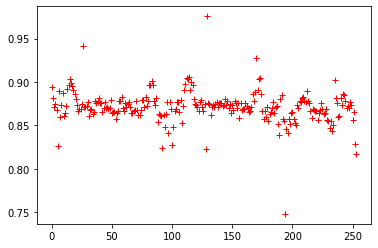

In [328]:
plt.plot(clean_set[1,:], 'r+')

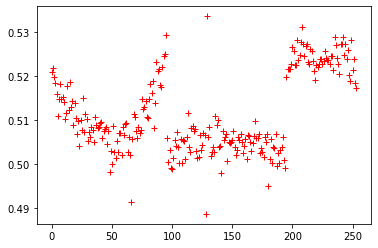

In [329]:
plt.plot(clean_set[0,:], 'r+')

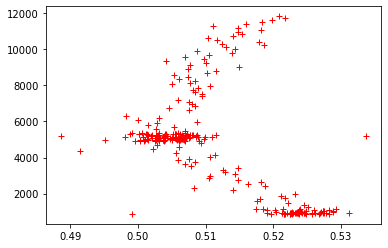

In [331]:
plt.plot(clean_set[0,:],clean_set[2,:], 'r+')

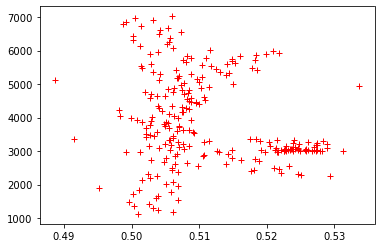

In [332]:
plt.plot(clean_set[0,:],clean_set[3,:], 'r+')

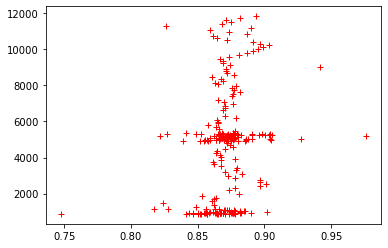

In [333]:
plt.plot(clean_set[1,:],clean_set[2,:], 'r+')

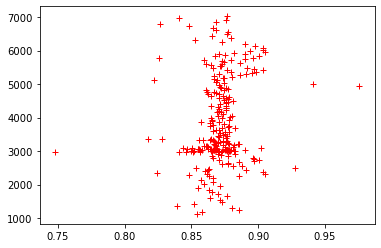

In [334]:
plt.plot(clean_set[1,:],clean_set[3,:], 'r+')

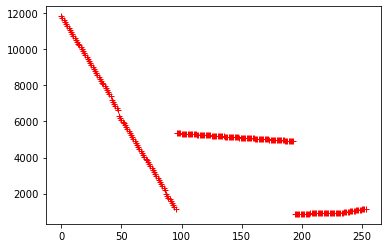

In [307]:
plt.plot(clean_set[2,:], 'r+')

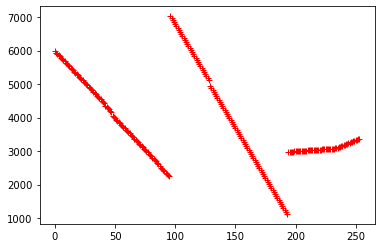

In [308]:
plt.plot(clean_set[3,:], 'r+')

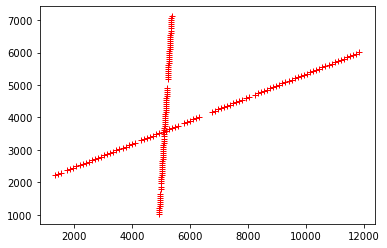

In [182]:
plt.plot(clean_set[2,:], clean_set[3,:], 'r+')

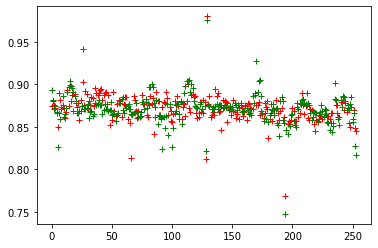

In [335]:
plt.plot(squaredfit_predicted_ans, 'r+')
#plt.plot(multi_lin_predict, 'b+')
plt.plot(clean_set[1], 'g+')

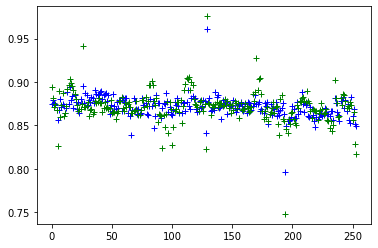

In [340]:
#plt.plot(squaredfit_predicted_ans, 'r+')
plt.plot(multi_lin_predict, 'b+')
plt.plot(clean_set[1], 'g+')

In [121]:
expected_intensities = get_expected_intensities(multi_lin_reg_parameter_bundle)
plt.plot(expected_intensities, clean_set[0,:]-expected_intensities,  'r+')

ValueError: too many values to unpack (expected 4)

In [30]:
def anorthise(image, anint_params):
    image_copy = image.copy()
    if len(anint_params) == 4:
        anint_params = np.insert(anint_params, 3, 0)
        print(anint_params)
    
    image_copy[image_copy<40/256] = 0
    points = np.nonzero(image)
    brightnesses = image[points]
    anorthites = points[1]*anint_params[0] + points[0]*anint_params[1]+ brightnesses*anint_params[2] + (brightnesses**2)*anint_params[3]+anint_params[4]
    image_copy[points] = anorthites
    image_copy[image_copy<0.6] = 0
    
    return image_copy, anorthites
    
    

In [31]:
def colourise(anorthites_image): #0-1 image please
    points = 0
    colours = plt.get_cmap('plasma')
    points = np.nonzero(anorthites_image)
    print(np.array(points).shape)
    rgba_shape = np.array((anorthites_image.shape[0], anorthites_image.shape[1], 4))
    anorthites_image_rgba = np.zeros((rgba_shape))
    anorthites_image_copy = (anorthites_image.copy()-0.6)/(1-0.6)
    #anorthites_image_copy[anorthites_image_copy == 0] = np.array([0,0,0,0])
    anorthites_image_rgba[points] = colours(anorthites_image_copy[points])
    #print(anorthites_image_copy[points].shape)
    #print(colours(anorthites_image[points]).shape)
    
    return anorthites_image_rgba, colours(anorthites_image_copy[points])
    
    
    
    

In [286]:
anint_test_params = multi_lin_reg_parameter_bundle

In [287]:
anorth_image, anorth_nums = anorthise(image, anint_test_params)

In [209]:
anorth_nums = 0

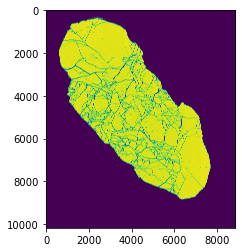

In [210]:
plt.imshow(anorth_image)

In [213]:
anorth_series = pd.Series(anorth_nums[::1000])

In [214]:
real_anorth_series = pd.Series(anorthite_list)

In [215]:
real_anorth_series

0      0.795742
1      0.861012
2      0.896795
3      0.895374
4      0.889862
         ...   
255    0.895992
256    0.873764
257    0.869140
258    0.868759
259    0.897276
Length: 260, dtype: float64

In [17]:
anorth_image_series = pd.Series(anorth_image.flatten()[::10000])

In [18]:
#anorth_image_series

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
9006    0.0
9007    0.0
9008    0.0
9009    0.0
9010    0.0
Length: 9011, dtype: float32

In [14]:
#anorth_series

0        0.374182
1        0.778066
2        0.881631
3        0.709452
4        0.904304
           ...   
32240    0.849428
32241    0.875664
32242    0.858357
32243    0.858169
32244    0.819414
Length: 32245, dtype: float64

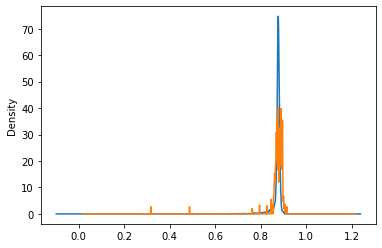

In [40]:
#ax = anorth_series.plot.kde(bw_method = 0.01) Geo mean John1
#ax = real_anorth_series.plot.kde(bw_method = 0.01)

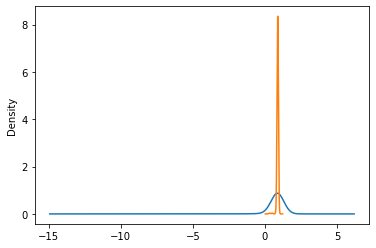

In [217]:
ax = anorth_series.plot.kde(bw_method = 1) #
ax = real_anorth_series.plot.kde(bw_method = 1)

In [22]:
anorth_image[np.nonzero(anorth_image)] = anorth_image[np.nonzero(anorth_image)]-0.75

In [23]:
anorth_image_series = pd.Series(anorth_image.flatten()[::10000])

In [24]:
anorth_image_series

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
9006    0.0
9007    0.0
9008    0.0
9009    0.0
9010    0.0
Length: 9011, dtype: float32

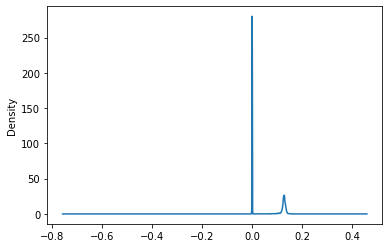

In [25]:
ax = anorth_image_series.plot.kde(bw_method = 0.01)

In [32]:
anorth_image[np.nonzero(anorth_image)] = anorth_image[np.nonzero(anorth_image)]+0.01

In [33]:
anorth_image_series = pd.Series(anorth_image.flatten()[::10000])

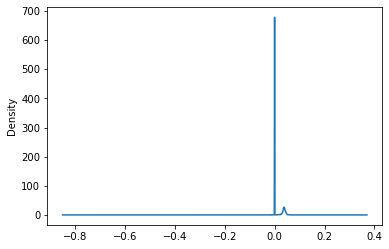

In [34]:
ax = anorth_image_series.plot.kde(bw_method = 0.01)

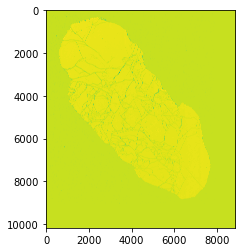

In [36]:
plt.imshow(anorth_image)

In [288]:
colour_im, colour_nums = colourise(anorth_image)

(2, 32233265)


In [221]:
anorth_image = 0

In [33]:
np.mean(colour_im[:,:,2])

0.11164683656655348

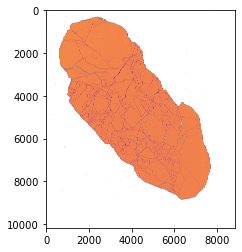

In [22]:
plt.imshow(colour_im)

In [23]:
colour_im.shape

(10178, 8853, 4)

In [289]:
to_save = (colour_im*255).astype(np.uint8)
to_save = Image.fromarray(to_save)
to_save.save('John1_offset_coloured.tif')